# <div align="center" style="color: #ff5733;">Income Estimation Regression Model (Catboost) Alpha</div>

In [1]:
def set_all_seeds(seed=42):
    """Set all seeds and environment variables for reproducibility"""
    import os
    # Set environment variables before any other imports
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    # Then set other seeds
    import numpy as np
    import random
    np.random.seed(seed)
    random.seed(seed)
    
    # Force single-thread operations
    os.environ['OMP_NUM_THREADS'] = '1'
    os.environ['MKL_NUM_THREADS'] = '1'
    os.environ['OPENBLAS_NUM_THREADS'] = '1'

# Delare libraries

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    r2_score, 
    mean_absolute_percentage_error
)
from catboost import CatBoostRegressor, Pool
import catboost as cb
from xgboost import XGBRegressor
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
import shap
from statsmodels.stats.outliers_influence import variance_inflation_factor
from typing import Union, List
from scipy.stats import mstats
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
import time

import pickle
from datetime import datetime
import re
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from fuzzywuzzy import fuzz
import joblib
from google.cloud import storage
from google.cloud import bigquery
# Connection to Bigquery
client = bigquery.Client(project='prj-prod-dataplatform')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Settings in this Notebook
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", None)





# Constants

In [3]:
# Constants

BUCKET_NAME = "prod-asia-southeast1-tonik-aiml-workspace"
CLOUDPATH = "Monthly_Income_Estimation/Income_Estimation_Alpha/Data"
CLOUDPATH_TARGET = "Monthly_Income_Estimation/Target_Encoded_Artifacts"
DATATYPE = "Step"
LOCALPATH = "/home/jupyter/Models/Income_Estimation_Alpha/"
LOCALPATHSRC = "/home/jupyter/Models/Income_Estimation_Alpha/src/"
LOCALPATHARTIFACTS = "/home/jupyter/Models/Income_Estimation_Alpha/Artifacts/"
MODELNAME = "Alpha"
VERSIONNAME = "1_0"
PRODUCT_TYPE = 'SIL_Quick'
CURRENT_DATE = datetime.now().strftime("%Y%m%d")

# Functions

## dfdescription

In [4]:
def dfdescription(df):
    print(f"The shape of the data frame is :\t {df.shape}")
    print(f"The data types of columns in dataframe is: \n{df.dtypes}")
    print(f"The description of numerical columns is:\t {df.describe()}")

## add_column_prefix

In [5]:
def add_column_prefix(df: pd.DataFrame, 
                      prefix: str, 
                      columns: Union[str, List[str]] = None):
    """
    Add a prefix to specified columns in a DataFrame.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame whose columns need to be renamed
    prefix : str
        The prefix to be added to selected column names
    columns : str or list of str, optional
        The specific column(s) to add prefix to. 
        If None, applies prefix to all columns.
    
    Returns:
    --------
    pandas.DataFrame
        A new DataFrame with prefixed column names
    
    Examples:
    ---------
    >>> data = pd.DataFrame({
    ...     'name': ['Alice', 'Bob'], 
    ...     'age': [25, 30], 
    ...     'city': ['New York', 'San Francisco']
    ... })
    >>> 
    >>> # Add prefix to specific columns
    >>> prefixed_data = add_column_prefix(data, 'user_', ['name', 'age'])
    >>> print(prefixed_data.columns)
    Index(['user_name', 'user_age', 'city'], dtype='object')
    
    >>> # Add prefix to all columns
    >>> all_prefixed = add_column_prefix(data, 'user_')
    >>> print(all_prefixed.columns)
    Index(['user_name', 'user_age', 'user_city'], dtype='object')
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()
    
    # If no specific columns are provided, use all columns
    if columns is None:
        columns = df.columns.tolist()
    
    # Ensure columns is a list
    if isinstance(columns, str):
        columns = [columns]
    
    # Validate that specified columns exist in the DataFrame
    invalid_columns = set(columns) - set(df.columns)
    if invalid_columns:
        raise ValueError(f"Columns not found in DataFrame: {invalid_columns}")
    
    # Create a dictionary to map selected column names to new column names
    rename_dict = {col: f"{prefix}{col}" for col in columns}
    
    # Rename the specified columns
    df_copy.rename(columns=rename_dict, inplace=True)
    
    return df_copy


## Upload_blob

In [6]:
def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket.   


    Args:
        bucket_name: The name of the bucket.
        source_file_name: The path to the file to upload.
        destination_blob_name: The name of the blob to be created.
    """
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_name)

    print(f"File {source_file_name} uploaded to {destination_blob_name}.")
    

## upload_model_to_gcs

In [7]:
# Upload the model to GCS
def upload_model_to_gcs(bucket_name, source_file_name, destination_blob_name):
    """Uploads a model to a GCS bucket.

    Args:
        bucket_name: The name of the GCS bucket.
        source_file_name: The path to the local model file.
        destination_blob_name: The name of the blob to be created in GCS.
    """
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_name) 
    


## plot_actual_vs_predicted

In [8]:
def plot_actual_vs_predicted(y_true, y_pred, title='Actual vs Predicted Values'):
    """
    Create a scatter plot of actual vs predicted values
    
    Parameters:
    - y_true: True target values
    - y_pred: Predicted target values
    - title: Plot title
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.tight_layout()
    plt.show()

## plot_residuals

In [9]:
def plot_residuals(y_true, y_pred, title='Residual Plot'):
    """
    Create a residual plot to visualize model errors with type conversion
    
    Parameters:
    - y_true: True target values
    - y_pred: Predicted target values
    - title: Plot title
    """
    # Convert to numpy float arrays to ensure type compatibility
    y_true_float = np.array(y_true, dtype=float)
    y_pred_float = np.array(y_pred, dtype=float)
    
    residuals = y_true_float - y_pred_float
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred_float, residuals, alpha=0.5)
    plt.hlines(y=0, xmin=y_pred_float.min(), xmax=y_pred_float.max(), color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(title)
    plt.tight_layout()
    plt.show()
    


## plot_residuals_hist

In [10]:
def plot_residuals_hist(y_true, y_pred, title='Residual Histogram Plot'):
    """
    Create a residual plot to visualize model errors with type conversion
    
    Parameters:
    - y_true: True target values
    - y_pred: Predicted target values
    - title: Plot title
    """
    # Convert to numpy float arrays to ensure type compatibility
    y_true_float = np.array(y_true, dtype=float)
    y_pred_float = np.array(y_pred, dtype=float)
    
    residuals = y_true_float - y_pred_float

    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Residual Histogram')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()
    


## plot_lift_chart  

In [11]:
def plot_lift_chart(y_test, y_pred, n_bins=10):
    """
    Plots a lift chart for a regression model.
    
    Parameters:
        y_test (array-like): Actual target values.
        y_pred (array-like): Predicted target values.
        n_bins (int): Number of bins/quantiles to group the data (default: 10).
    
    Returns:
        None: Displays the lift chart.
    """
    # Combine actual and predicted values into a DataFrame
    results = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred
    })
    
    # Create quantile-based bins
    results['Decile'] = pd.qcut(results['Predicted'], q=n_bins, labels=False)

    # Group by decile and calculate mean actual and predicted values
    lift_chart_data = results.groupby('Decile').agg(
        Avg_Predicted=('Predicted', 'mean'),
        Avg_Actual=('Actual', 'mean')
    ).reset_index()

    # Plot the lift chart
    plt.figure(figsize=(10, 6))
    plt.plot(lift_chart_data['Avg_Predicted'], label='Predicted', marker='o')
    plt.plot(lift_chart_data['Avg_Actual'], label='Actual', marker='s')
    plt.title("Lift Chart")
    plt.xlabel(f"Decile (1-{n_bins})")
    plt.ylabel("Average Value")
    plt.legend()
    plt.grid()
    plt.show()



## plot_gain_chart

In [12]:
def plot_gain_chart(y_test, y_pred, n_bins=10):
    """
    Plots a gain chart for a regression model.
    
    Parameters:
        y_test (array-like): Actual target values.
        y_pred (array-like): Predicted target values.
        n_bins (int): Number of bins/quantiles to group the data (default: 10).
    
    Returns:
        None: Displays the gain chart.
    """
    # Combine actual and predicted values into a DataFrame
    results = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred
    })

    # Sort by predicted values
    results = results.sort_values(by='Predicted', ascending=False).reset_index(drop=True)

    # Calculate cumulative sums for actual and predicted values
    results['Cumulative_Actual'] = results['Actual'].cumsum()
    results['Cumulative_Predicted'] = results['Predicted'].cumsum()

    # Normalize cumulative sums to percentage of total
    results['Cumulative_Actual_Percent'] = results['Cumulative_Actual'] / results['Actual'].sum() * 100
    results['Cumulative_Predicted_Percent'] = results['Cumulative_Predicted'] / results['Predicted'].sum() * 100
    results['Percentage_of_Data'] = np.linspace(1 / len(results), 1, len(results)) * 100

    # Plot the gain chart
    plt.figure(figsize=(10, 6))
    plt.plot(results['Percentage_of_Data'], results['Cumulative_Predicted_Percent'], label='Predicted', marker='o')
    plt.plot(results['Percentage_of_Data'], results['Cumulative_Actual_Percent'], label='Actual', marker='s')
    plt.title("Gain Chart")
    plt.xlabel("Percentage of Data")
    plt.ylabel("Cumulative Percentage")
    plt.legend()
    plt.grid()
    plt.show()



## save_df_to_gcs

In [13]:
def save_df_to_gcs(df, bucket_name, destination_blob_name, file_format='csv'):
    """Saves a pandas DataFrame to Google Cloud Storage.

    Args:
        df: The pandas DataFrame to save.
        bucket_name: The name of the GCS bucket.
        destination_blob_name: The name of the blob to be created.
        file_format: The file format to save the DataFrame in ('csv' or 'parquet').
    """

    # Create a temporary file
    if file_format == 'csv':
        temp_file = 'temp.csv'
        df.to_csv(temp_file, index=False)
    elif file_format == 'parquet':
        temp_file = 'temp.parquet'
        df.to_parquet(temp_file, index=False)
    else:
        raise ValueError("Invalid file format. Please choose 'csv' or 'parquet'.")

    # Upload the file to GCS
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(temp_file)

    # Remove the temporary file
    import os
    os.remove(temp_file)
    


## read_csv_from_gcs

In [14]:
def read_csv_from_gcs(project_id, bucket_name, file_path):
  """Reads a CSV file from a GCS bucket into a pandas DataFrame.

  Args:
    project_id: The Google Cloud project ID.
    bucket_name: The name of the GCS bucket.
    file_path: The path to the CSV file within the bucket.

  Returns:
    A pandas DataFrame containing the CSV data.
  """

  storage_client = storage.Client(project=project_id)
  bucket = storage_client.bucket(bucket_name)
  blob = bucket.blob(file_path)

  with blob.open('r') as f:
    df = pd.read_csv(f)

  return df



In [15]:
## check_categorical_columns

def check_categorical_columns(df, categorical_cols):
    """
    Check if any categorical columns contain numerical values or NaNs.
    """
    for col in categorical_cols:
        if df[col].dtype != 'object':  # Check if the column is not of type 'object'
            print(f"Column {col} is not of type 'object'. It has type: {df[col].dtype}")
            print(f"Unique values in {col}: {df[col].unique()}")
        elif df[col].isnull().any():  # Check if the column contains NaN values
            print(f"Column {col} contains NaN values.")
        else:
            print(f"Column {col} seems fine.")
        
        # Check for numerical data in categorical columns
        numerical_data = df[col][df[col].apply(lambda x: isinstance(x, (int, float)))]
        if not numerical_data.empty:
            print(f"Column {col} contains numerical data: {numerical_data.unique()}")

# # List of categorical columns
# categorical_cols = ['de_gender', 'de_maritalStatus', 'de_city', 'de_barangay', 'de_province',
#                     'de_dependentsCount', 'de_subIndustryDescription', 'de_Education_type',
#                     'deviceType', 'osversion_v2', 'brand', 'app_first_app_cat',
#                     'app_last_app_cat', 'de_natureofwork_grouped']


## load_pickle_from_gcs

In [16]:
def load_pickle_from_gcs(bucket_name, blob_path):
    """
    Load pickle file from Google Cloud Storage
    
    Parameters:
    bucket_name: Name of the GCS bucket
    blob_path: Path to the blob in the bucket
    
    Returns:
    Unpickled data
    """
    from google.cloud import storage
    import pickle
    import io
    
    # Initialize GCS client
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(blob_path)
    
    # Download blob content into memory
    content = blob.download_as_bytes()
    
    # Load pickle data from memory
    pickle_data = pickle.loads(content)
    
    return pickle_data


# Data Ingestion

## Beta2 Query Data

In [17]:
data_filename = '20250204_Alpha_SIL_Quick1_0_Beta2data.csv'
project_id = 'prj-prod-dataplatform'
bucket_name = BUCKET_NAME
file_path = f'{CLOUDPATH}/{data_filename}'

dfbeta2 = read_csv_from_gcs(project_id, bucket_name, file_path)
print(f"The shape of the {CLOUDPATH}/{data_filename} is :\t {dfbeta2.shape}")



The shape of the Monthly_Income_Estimation/Income_Estimation_Alpha/Data/20250204_Alpha_SIL_Quick1_0_Beta2data.csv is :	 (102969, 42)


In [18]:
# Find duplicate values
duplicates = dfbeta2[dfbeta2.duplicated(subset=['digitalLoanAccountId'], keep=False)]  # keep=False marks all duplicates as True

# Print the duplicate rows
if len(duplicates) <= 0:
    print(f"There is no duplicates found")
else:
    print(duplicates)

There is no duplicates found


## CIC Data

In [19]:
data_filename = '20250204_Alpha_SIL_Quick1_0_CIC_Feature_Master_table.csv'
project_id = 'prj-prod-dataplatform'
bucket_name = BUCKET_NAME
file_path = f'{CLOUDPATH}/{data_filename}'

dfcic = read_csv_from_gcs(project_id, bucket_name, file_path)
print(f"The shape of the {CLOUDPATH}/{data_filename} is :\t {dfcic.shape}")

The shape of the Monthly_Income_Estimation/Income_Estimation_Alpha/Data/20250204_Alpha_SIL_Quick1_0_CIC_Feature_Master_table.csv is :	 (34895, 171)


In [20]:
# Find duplicate values
duplicates = dfcic[dfcic.duplicated(subset=['digitalLoanAccountId'], keep=False)]  # keep=False marks all duplicates as True

# Print the duplicate rows
if len(duplicates) <= 0:
    print(f"There is no duplicates found")
else:
    print(duplicates)

There is no duplicates found


## Merge Beta2 and CIC data

In [21]:
dfmerged = dfbeta2.merge(dfcic, on='digitalLoanAccountId', how='left')
a = (dfmerged.isnull().sum()/102969)*100
# df = pd.DataFrame(a, columns=['values'])
missing_percentage = (dfmerged.isna().sum() / len(dfmerged)) * 100
# Display in descending order
missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=False)

In [22]:
missing_percentage

cnt_active_contracts_Time_Loans                   100.000000
Time_Loans_granted_contracts_amt_24M              100.000000
Time_Loans_granted_contracts_amt_12M              100.000000
Time_Loans_granted_contracts_amt_6M               100.000000
Time_Loans_granted_contracts_cnt_24M              100.000000
Time_Loans_granted_contracts_cnt_12M              100.000000
Time_Loans_granted_contracts_cnt_6M               100.000000
Time_Loans_active_contracts_util                  100.000000
Trust_Loans_granted_contracts_amt_6M               99.999029
Home_Equity_Loans_granted_contracts_amt_12M        99.999029
Home_Equity_Loans_granted_contracts_cnt_12M        99.999029
Trust_Loans_granted_contracts_cnt_6M               99.999029
Home_Equity_Loans_granted_contracts_amt_24M        99.998058
Trust_Loans_active_contracts_util                  99.998058
cnt_active_contracts_Trust_Loans                   99.998058
Home_Equity_Loans_granted_contracts_cnt_24M        99.998058
Trust_Loans_granted_cont

In [23]:
dfmerged.columns.values
df = dfmerged[['digitalLoanAccountId', 'onboarding_datetime', 'age', 'Gender', 'email', 'onb_mobile_no',
       'loan_mobile_no', 'onb_mobile_Not_match_loan_mobile',  'flag_alternate_mobile_provided', 'loan_purpose', 'source_funds',
       'employment_type', 'nature_of_work', 'industry_description',   'loan_company_name', 'maritalStatus', 'dependentsCount',
       'loan_education_level', 'loan_ref_type1', 'loan_ref_type2',   'loan_province', 'loan_city', 'loan_barangay', 'loan_postalcode',
       'loan_geolocation', 'loan_product_type', 'osversion_v2',    'clean_version', 'loan_brand', 'monthlyIncome',
       'loan_monthly_income', 'loan_vas_opted_flag', 'Dataselection',   'place_of_birth', 'onb_latitude', 'onb_longitude', 'loan_docType', 'loan_docNumber', 'daystoapply',
        'cnt_active_contracts',      'cnt_active_contracts_Credit_Cards',     'cnt_active_contracts_Credit_Lines',
       'cnt_active_contracts_Home_Equity_Loans',       'cnt_active_contracts_Other_Loans',       'cnt_active_contracts_Personal_Loans',
       'cnt_active_contracts_Real_Estate_Loans',       'cnt_active_contracts_Short_and_Term_Loans',       'cnt_active_contracts_Time_Loans',
       'cnt_active_contracts_Trust_Loans', 'max_amt_active_contracts',       'tot_active_contracts_os_amt', 'tot_active_contracts_util',
       'Credit_Cards_active_contracts_util',       'Credit_Lines_active_contracts_util',       'Home_Equity_Loans_active_contracts_util',
       'Other_Loans_active_contracts_util',       'Personal_Loans_active_contracts_util',       'Real_Estate_Loans_active_contracts_util',
       'Short_and_Term_Loans_active_contracts_util',       'Time_Loans_active_contracts_util',       'Trust_Loans_active_contracts_util', 'last_repay_amt_30d',
       'highest_latest_repay_method_30d', 'last_repay_amt_60d',       'highest_latest_repay_method_60d', 'last_repay_amt_90d',
       'highest_latest_repay_method_90d', 'last_repay_amt',       'highest_latest_repay_method', 'max_age_active_contracts_snapshot',
       'max_age_all_contracts_snapshot', 'days_since_last_inquiry',
       'days_since_last_grant', 'days_since_last_closed',       'days_since_last_repay', 'days_since_last_reject',
       'days_since_last_renounce',       'Credit_Cards_granted_contracts_cnt_6M',
       'Credit_Lines_granted_contracts_cnt_6M',       'Other_Loans_granted_contracts_cnt_6M',       'Personal_Loans_granted_contracts_cnt_6M',
       'Real_Estate_Loans_granted_contracts_cnt_6M',       'Short_and_Term_Loans_granted_contracts_cnt_6M',       'Time_Loans_granted_contracts_cnt_6M',
       'Trust_Loans_granted_contracts_cnt_6M',       'Credit_Cards_granted_contracts_cnt_12M',       'Credit_Lines_granted_contracts_cnt_12M',
       'Home_Equity_Loans_granted_contracts_cnt_12M',       'Other_Loans_granted_contracts_cnt_12M',       'Personal_Loans_granted_contracts_cnt_12M',
       'Real_Estate_Loans_granted_contracts_cnt_12M',       'Short_and_Term_Loans_granted_contracts_cnt_12M',       'Time_Loans_granted_contracts_cnt_12M',
       'Trust_Loans_granted_contracts_cnt_12M',       'Credit_Cards_granted_contracts_cnt_24M',       'Credit_Lines_granted_contracts_cnt_24M',
       'Home_Equity_Loans_granted_contracts_cnt_24M',       'Other_Loans_granted_contracts_cnt_24M',       'Personal_Loans_granted_contracts_cnt_24M',
       'Real_Estate_Loans_granted_contracts_cnt_24M',       'Short_and_Term_Loans_granted_contracts_cnt_24M',       'Time_Loans_granted_contracts_cnt_24M',
       'Trust_Loans_granted_contracts_cnt_24M',       'granted_contracts_cnt_6M', 'granted_contracts_cnt_12M',
       'granted_contracts_cnt_24M',       'Credit_Cards_granted_contracts_amt_6M',
       'Credit_Lines_granted_contracts_amt_6M',       'Other_Loans_granted_contracts_amt_6M',       'Personal_Loans_granted_contracts_amt_6M',
       'Real_Estate_Loans_granted_contracts_amt_6M',       'Short_and_Term_Loans_granted_contracts_amt_6M',
       'Time_Loans_granted_contracts_amt_6M',       'Trust_Loans_granted_contracts_amt_6M',       'Credit_Cards_granted_contracts_amt_12M',
       'Credit_Lines_granted_contracts_amt_12M',       'Home_Equity_Loans_granted_contracts_amt_12M',
       'Other_Loans_granted_contracts_amt_12M',       'Personal_Loans_granted_contracts_amt_12M',
       'Real_Estate_Loans_granted_contracts_amt_12M',
       'Short_and_Term_Loans_granted_contracts_amt_12M',
       'Time_Loans_granted_contracts_amt_12M',
       'Trust_Loans_granted_contracts_amt_12M',
       'Credit_Cards_granted_contracts_amt_24M',
       'Credit_Lines_granted_contracts_amt_24M',
       'Home_Equity_Loans_granted_contracts_amt_24M',
       'Other_Loans_granted_contracts_amt_24M',
       'Personal_Loans_granted_contracts_amt_24M',
       'Real_Estate_Loans_granted_contracts_amt_24M',
       'Short_and_Term_Loans_granted_contracts_amt_24M',
       'Time_Loans_granted_contracts_amt_24M',
       'Trust_Loans_granted_contracts_amt_24M',
       'tot_granted_contracts_amt_6M', 'tot_granted_contracts_amt_12M',
       'tot_granted_contracts_amt_24M', 'avg_amt_granted_12M',
       'min_amt_granted_12M', 'max_amt_granted_12M',
       'avg_amt_granted_24M', 'min_amt_granted_24M',
       'max_amt_granted_24M', 'avg_amt_granted_6M', 'min_amt_granted_6M',
       'max_amt_granted_6M', 'med_days_bw_contracts_12m',
       'avg_days_bw_contracts_12m', 'cnt_foreclosed_contracts_6M',
       'cnt_foreclosed_contracts_12M', 'cnt_foreclosed_contracts_24M',
       'cnt_writeoff_ever', 'vel_contract_granted_cnt_3on12',
       'vel_contract_granted_cnt_6on12',
       'vel_contract_granted_cnt_12on24',
       'vel_contract_granted_amt_3on12', 'vel_contract_granted_amt_6on12',
       'vel_contract_granted_amt_12on24', 'vel_contract_closed_amt_3on12',
       'vel_contract_closed_amt_6on12', 'vel_contract_closed_amt_12on24',
       'avg_credit_limit_12M', 'min_credit_limit_12M',
       'max_credit_limit_12M', 'avg_financed_amt_12M',
       'min_financed_amt_12M', 'max_financed_amt_12M',
       'ratio_closed_over_new_granted_cnt_6M',
       'ratio_closed_over_new_granted_cnt_12M',
       'ratio_closed_over_new_granted_cnt_24M',
       'ratio_closed_over_new_granted_amt_6M',
       'ratio_closed_over_new_granted_amt_12M',
       'ratio_closed_over_new_granted_amt_24M',
       'min_ratio_charged_on_sanctioned_6M',
       'max_ratio_charged_on_sanctioned_6M',
       'avg_ratio_charged_on_sanctioned_6M',
       'min_ratio_charged_on_sanctioned_12M',
       'max_ratio_charged_on_sanctioned_12M',
       'avg_ratio_charged_on_sanctioned_12M',
       'min_ratio_charged_on_sanctioned_24M',
       'max_ratio_charged_on_sanctioned_24M',
       'avg_ratio_charged_on_sanctioned_24M', 'min_no_of_installments_6M',
       'max_no_of_installments_6M', 'avg_no_of_installments_6M',
       'min_no_of_installments_12M', 'max_no_of_installments_12M',
       'avg_no_of_installments_12M', 'min_no_of_installments_24M',
       'max_no_of_installments_24M', 'avg_no_of_installments_24M',
       'cnt_nongranted_contracts_3M', 'amt_nongranted_contracts_3M',
       'vel_contract_nongranted_cnt_3on12',
       'vel_contract_nongranted_cnt_6on12',
       'vel_contract_nongranted_cnt_12on24',
       'vel_contract_nongranted_amt_3on12',
       'vel_contract_nongranted_amt_6on12',
       'vel_contract_nongranted_amt_12on24',
       'ratio_coborrow_contracts_cnt_24M',
       'ratio_coborrow_contracts_amt_24M', 'CreditMaxOverdueDays',       'CreditAvgCreditLimit', 'accountsOverduePct',   'NonInstAvgCreditLimit', 'ScoreRange'      
              ]].copy()

In [24]:
null_percentage = (df.isnull().sum() / len(df)) * 100

print(null_percentage)

digitalLoanAccountId                                0.000000
onboarding_datetime                                 0.000000
age                                                 0.000000
Gender                                              0.000000
email                                               0.000000
onb_mobile_no                                       0.000000
loan_mobile_no                                      0.000000
onb_mobile_Not_match_loan_mobile                    0.000000
flag_alternate_mobile_provided                      0.000000
loan_purpose                                        0.000000
source_funds                                        1.717993
employment_type                                     0.000000
nature_of_work                                     69.414096
industry_description                               14.722878
loan_company_name                                  20.779069
maritalStatus                                       0.000000
dependentsCount         

In [25]:
import pandas as pd

def remove_high_missing_features(df, threshold=0.95):
    """
    Removes features with missing values exceeding a specified threshold.

    Args:
        df: Pandas DataFrame.
        threshold: The percentage threshold for missing values (default: 0.95).

    Returns:
        Pandas DataFrame with the high-missing-value features removed.
    """

    # Calculate the percentage of missing values for each column
    missing_percentage = df.isnull().sum() / len(df)

    # Identify columns exceeding the threshold
    columns_to_drop = missing_percentage[missing_percentage > threshold].index

    # Drop the identified columns
    df = df.drop(columns=columns_to_drop)

    return df



# Apply the function to remove features with > 95% missing values
df_cleaned = remove_high_missing_features(df)

# Print the shape of the original and cleaned DataFrames to see the difference
print("Original DataFrame shape:", df.shape)
print("Cleaned DataFrame shape:", df_cleaned.shape)


# Save the cleaned DataFrame to a new CSV file (optional)
df_cleaned.to_csv('loan_data_cleaned.csv', index=False)

Original DataFrame shape: (102969, 204)
Cleaned DataFrame shape: (102969, 91)


In [26]:
null_percentage = (df_cleaned.isnull().sum() / len(df_cleaned)) * 100

print(null_percentage)

digitalLoanAccountId                      0.000000
onboarding_datetime                       0.000000
age                                       0.000000
Gender                                    0.000000
email                                     0.000000
onb_mobile_no                             0.000000
loan_mobile_no                            0.000000
onb_mobile_Not_match_loan_mobile          0.000000
flag_alternate_mobile_provided            0.000000
loan_purpose                              0.000000
source_funds                              1.717993
employment_type                           0.000000
nature_of_work                           69.414096
industry_description                     14.722878
loan_company_name                        20.779069
maritalStatus                             0.000000
dependentsCount                          36.118638
loan_education_level                      8.251998
loan_ref_type1                            8.251998
loan_ref_type2                 

# EDA

In [27]:
df = df_cleaned.copy()

In [28]:
print(f"The shape of the dataframe after cleaning is:\t {df.shape}")

The shape of the dataframe after cleaning is:	 (102969, 91)


In [29]:
print(f"The source of fund is:\n{df['source_funds'].value_counts(dropna=False)}")
print(f"The nature of work is:\n {df['nature_of_work'].value_counts(dropna=False)}")
print(f"The industry_description is:\n{df['industry_description'].value_counts(dropna=False)}")
print(f"The dependentsCount is:\n{df['dependentsCount'].value_counts(dropna=False)}")

The source of fund is:
source_funds
Salary                                  70212
Income from Business                    17404
Remittance                              13350
NaN                                      1769
Allowance                                 175
Inheritance/Retirement Funds               35
Pension                                    14
Interest on Deposits and Investments       10
Name: count, dtype: int64
The nature of work is:
 nature_of_work
NaN                                   71475
Licensed Professional - Others        14960
Govt Employee                          6039
Sales/Marketing Personnel              4600
Owner                                  2481
Licensed Professional - Accountant     1898
Manager/Executive                      1394
Broker/Dealer                           100
Licensed Professional - Lawyer           22
Name: count, dtype: int64
The industry_description is:
industry_description
NaN                                                      15

# Custom Transformers

## DateTimeFeatureTransformer

In [30]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class DateTimeFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.time_bins = [-1, 3, 9, 18, 24]
        self.time_labels = ['12am-3am', '4am-8am', '9am-6pm', '7pm-12am']
        self.feature_names = [
            'Onboarding_time_of_day',
            'Onboarding_time_of_day_cat',
            'Onboarding_mon_of_year',
            'Onboarding_week_of_month',
            'Onboarding_day_of_week',
            'Onboarding_Is_Weekend'
        ]
        self.output_format = "default"  # Default output format

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if isinstance(X, pd.Series):
            X = pd.DataFrame(X)

        # Check if 'onboarding_datetime' column is available
        if 'onboarding_datetime' not in X.columns:
            return X.to_numpy() if self.output_format != "pandas" else X

        # Convert to datetime if not already
        X_copy = X.copy()
        X_copy['onboarding_datetime'] = pd.to_datetime(X_copy['onboarding_datetime'])

        # Extract features
        features = pd.DataFrame()

        # Time of day
        features['Onboarding_time_of_day'] = X_copy['onboarding_datetime'].dt.hour
        features['Onboarding_time_of_day_cat'] = pd.cut(
            features['Onboarding_time_of_day'],
            bins=self.time_bins,
            labels=self.time_labels,
            right=False
        )

        # Month and week features
        features['Onboarding_mon_of_year'] = X_copy['onboarding_datetime'].dt.month
        features['Onboarding_week_of_month'] = ((X_copy['onboarding_datetime'].dt.day - 1) // 7 + 1)
        features['Onboarding_week_of_month'] = features['Onboarding_week_of_month'].apply(lambda x: f"Wk{x}")

        # Day of week features
        features['Onboarding_day_of_week'] = X_copy['onboarding_datetime'].dt.day_name()
        features['Onboarding_Is_Weekend'] = features['Onboarding_day_of_week'].apply(
            lambda x: 'Weekend' if x in ['Sunday', 'Saturday'] else 'Weekday'
        )

        # Return output based on the configured format
        if self.output_format == "pandas":
            return features
        else:
            return features.to_numpy()

    def get_feature_names_out(self, input_features=None):
        return self.feature_names

    def set_output(self, transform="default"):
        """
        Set the output format of the transformer.
        """
        self.output_format = transform
        return self

## TelecomProviderTransformer

In [31]:
class TelecomProviderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.output_format = "default"  # Default output format

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['onboard_mobile_initials'] = X['onb_mobile_no'].astype(str).str[-10:].str[:3]

        X['onboard_telconame'] = np.where(X['onboard_mobile_initials'].isin(['904', '905', '906', '915', '916', '917', '926', '927', '935', '936', '937', '945', '952', '953', '954', '955', '956', '957', '958', '959', '965', '966', '967', '975', '976', '977', '978', '979', '995', '996', '997', '817', '917', '925']), 'Globe',
                                    np.where(X['onboard_mobile_initials'].isin(['813', '900', '907', '908', '909', '910', '911', '912', '913', '914', '918', '919', '920', '921', '928', '929', '930', '938', '939', '940', '946', '947', '948', '949', '950', '951', '960', '961', '963', '964', '968', '969', '970', '971', '980', '981', '982', '985', '989', '998', '999', '922', '923', '924', '925', '931', '932', '933', '934', '941', '942', '943', '944', '962', '972', '973', '974']), 'Smart',
                                        np.where(X['onboard_mobile_initials'].isin(['991', '992', '993', '994', '895', '896', '897', '898']), 'DITO',  'Other'  )))

        # Return output based on the configured format
        if self.output_format == "pandas":
            return X[['onboard_telconame']]
        else:
            return X[['onboard_telconame']].to_numpy()

    def get_feature_names_out(self, input_features=None):
        return ['onboard_telconame']

    def set_output(self, transform="default"):
        """
        Set the output format of the transformer.
        """
        self.output_format = transform
        return self

## FuzzyMatchTransformer

In [32]:
class FuzzyMatchTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, col1, col2, threshold=50):
        self.col1 = col1
        self.col2 = col2
        self.threshold = threshold
        self.output_format = "default"  # Default output format

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Ensure the columns are strings and lowercase
        X[[self.col1, self.col2]] = X[[self.col1, self.col2]].astype(str).apply(lambda x: x.str.lower())

        # Calculate fuzzy similarity and create a list of flags based on the threshold
        similarity_flags = X.apply(
            lambda row: 1 if fuzz.ratio(row[self.col1], row[self.col2]) >= self.threshold else 0,
            axis=1
        ).tolist()

        # Return as a DataFrame to be compatible with ColumnTransformer
        result = pd.DataFrame(similarity_flags, columns=[f'diff_in_{self.col1}_{self.col2}_flag'])

        # Return output based on the configured format
        if self.output_format == "pandas":
            return result
        else:
            return result.to_numpy()

    def get_feature_names_out(self, input_features=None):
        return [f'diff_in_{self.col1}_{self.col2}_flag']

    def set_output(self, transform="default"):
        """
        Set the output format of the transformer.
        """
        self.output_format = transform
        return self

## DocumentTypeOSVersionTransformer

In [33]:
class DocumentTypeOSVersionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.output_format = "default"  # Default output format

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()

        # Document Type Categorization
        X['docType_category'] = np.where(
            X['onb_document_type'].str.contains('Driving License', na=False, case=False), 'Driving License',
            np.where(
                X['onb_document_type'].str.contains('UMID Card', na=False, case=False), 'UMID Card',
                np.where(
                    X['onb_document_type'].str.contains('ePassport|Passport', na=False, case=False), 'Passport',
                    np.where(
                        X['onb_document_type'].str.contains('Postal Id Card', na=False, case=False), 'Postal ID Card',
                        np.where(
                            X['onb_document_type'].str.contains('Social Security Card', na=False, case=False), 'Social Security Card',
                            np.where(
                                X['onb_document_type'].str.contains('Professional Id Card', na=False, case=False), 'Professional ID Card',
                                np.where(
                                    X['onb_document_type'].str.contains('Voter Card|Voting Card', na=False, case=False), 'Voter Card',
                                    np.where(
                                        X['onb_document_type'].str.contains('PhilID|National ID', na=False, case=False), 'National ID',
                                        'Others'
                                    ))))))))

        # OS Version Categorization
        X['devicevrs_Type'] = np.where(X['osversion_v2'].str.startswith('android'), 'android',
                                 np.where(X['osversion_v2'].str.startswith('ios'), 'ios', 'other'))

        # Return output based on the configured format
        if self.output_format == "pandas":
            return X[['docType_category', 'devicevrs_Type']]
        else:
            return X[['docType_category', 'devicevrs_Type']].to_numpy()

    def get_feature_names_out(self, input_features=None):
        return ['docType_category', 'devicevrs_Type']

    def set_output(self, transform="default"):
        """
        Set the output format of the transformer.
        """
        self.output_format = transform
        return self

## FuzzyNameEmailMatcher

In [34]:
class FuzzyNameEmailMatcher(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=80):
        self.threshold = threshold
        self.output_format = "default"  # Default output format

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['flg_name_&_email_match'] = X.apply(self._fuzzy_match_name_email, axis=1)

        # Return output based on the configured format
        if self.output_format == "pandas":
            return X[['flg_name_&_email_match']]
        else:
            return X[['flg_name_&_email_match']].to_numpy()

    def _fuzzy_match_name_email(self, row):
        first_name = row['first_name']
        middle_name = row['middle_name'] if pd.notna(row['middle_name']) else ''  # Handle NaN
        last_name = row['last_name']
        email = row['email']

        # Extract the local part of the email (before @)
        email_local = email.split('@')[0].lower()

        # Check similarity using fuzzy matching
        first_name_match = fuzz.partial_ratio(first_name.lower(), email_local) >= self.threshold
        middle_name_match = fuzz.partial_ratio(middle_name.lower(), email_local) >= self.threshold if middle_name else False
        last_name_match = fuzz.partial_ratio(last_name.lower(), email_local) >= self.threshold

        # If any of the parts matches, return 1, else 0
        if first_name_match or middle_name_match or last_name_match:
            return 1
        else:
            return 0

    def get_feature_names_out(self, input_features=None):
        return ['flg_name_&_email_match']

    def set_output(self, transform="default"):
        """
        Set the output format of the transformer.
        """
        self.output_format = transform
        return self

## EmailFeatureTransformer

In [35]:
class EmailFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.domain_freq = None
        self.output_format = "default"  # Default output format

    def fit(self, X, y=None):
        if 'email' in X.columns:
            X['email'].str.lower()
            domains = X['email'].apply(lambda x: x.split('@')[1])
            self.domain_freq = domains.value_counts().to_dict()
        return self

    def transform(self, X, y=None):
        if 'email' not in X.columns:
            return pd.DataFrame()

        X_transformed = X.copy()
        X_transformed['domain'] = X_transformed['email'].apply(lambda x: x.split('@')[1])
        X_transformed['tld'] = X_transformed['domain'].apply(lambda x: x.split('.')[-1])

        # Return output based on the configured format
        if self.output_format == "pandas":
            return X_transformed[['domain', 'tld']]
        else:
            return X_transformed[['domain', 'tld']].to_numpy()

    def get_feature_names_out(self, input_features=None):
        return ['domain', 'tld']

    def set_output(self, transform="default"):
        """
        Set the output format of the transformer.
        """
        self.output_format = transform
        return self

## VersionCategorizer

In [36]:
class VersionCategorizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.output_format = "default"  # Default output format

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['osversionType'] = X.apply(self._categorize, axis=1)

        # Return output based on the configured format
        if self.output_format == "pandas":
            return X[['osversionType']]
        else:
            return X[['osversionType']].to_numpy()

    def _categorize(self, row):
        os_version = str(row['osversion_v2']).lower()
        clean_version = row['clean_version']

        if 'android' in os_version:
            if clean_version >= 15:
                return '5-Pioneer'
            elif clean_version == 14:
                return '4-Innovator'
            elif clean_version == 7:
                return '3-ComfortSeeker'
            elif clean_version in [13, 12, 11, 10, 6]:
                return '2-Voyager'
        elif 'ios' in os_version:
            if clean_version >= 18:
                return '5-Pioneer'
            elif clean_version in [17, 16]:
                return '3-ComfortSeeker'
            elif clean_version in [15, 14]:
                return '2-Voyager'
        return '1-Nomad'

    def get_feature_names_out(self, input_features=None):
        return ['osversionType']

    def set_output(self, transform="default"):
        """
        Set the output format of the transformer.
        """
        self.output_format = transform
        return self

## NatureOfWorkTransformer

In [37]:
class NatureOfWorkTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=50):
        self.threshold = threshold
        self.mapping = None
        self.column_present = False
        self.output_format = "default"  # Default output format

    def fit(self, X, y=None):
        if 'nature_of_work' in X.columns:
            self.column_present = True
            value_counts = X['nature_of_work'].value_counts()
            self.mapping = {work: 'Others' if count < self.threshold else work 
                          for work, count in value_counts.items()}
        return self

    def transform(self, X, y=None):
        if not self.column_present or 'nature_of_work' not in X.columns:
            return pd.DataFrame()

        X_transformed = X.copy()
        X_transformed['nature_of_work_grouped'] = X_transformed['nature_of_work'].map(self.mapping)

        # Return output based on the configured format
        if self.output_format == "pandas":
            return X_transformed[['nature_of_work_grouped']]
        else:
            return X_transformed[['nature_of_work_grouped']].to_numpy()

    def get_feature_names_out(self, input_features=None):
        return ['nature_of_work_grouped']

    def set_output(self, transform="default"):
        """
        Set the output format of the transformer.
        """
        self.output_format = transform
        return self

## TextClusteringTransformer

In [38]:
class TextClusteringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, col1, col2, n_clusters=6, vector_size=50, window=3, min_count=1, sg=0):
        self.col1 = col1
        self.col2 = col2
        self.n_clusters = n_clusters
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.sg = sg
        self.model = None
        self.kmeans = None
        self.output_format = "default"  # Default output format

    def clean_word(self, word):
        word = str(word).replace('/', ' ')
        return re.sub(r'[^\w\s]', '', word)

    def remove_extra_spaces(self, sentence):
        return re.sub(r'\s+', ' ', str(sentence)).strip()

    def get_vector(self, sentence, model, vector_size=50):
        words = sentence.split()
        vec = np.zeros(vector_size)
        count = 0
        for word in words:
            if word in model.wv:
                vec += model.wv[word]
                count += 1
        if count > 0:
            vec /= count
        return vec

    def fit(self, X, y=None):
        X = X.copy()
        X[self.col1] = X[self.col1].str.lower()
        X[self.col2] = X[self.col2].str.lower()

        X[self.col1] = X[self.col1].fillna('missing')
        X[self.col2] = X[self.col2].fillna('missing')

        X['company_and_industry'] = X[self.col1] + ' ' + X[self.col2]
        X['company_and_industry'] = X['company_and_industry'].apply(
            lambda x: self.remove_extra_spaces(' '.join([self.clean_word(word) for word in str(x).split()])))

        sentences = X['company_and_industry'].apply(lambda x: x.split())
        self.model = Word2Vec(sentences, vector_size=self.vector_size, window=self.window, 
                            min_count=self.min_count, sg=self.sg)

        X_vectors = np.vstack(X['company_and_industry'].apply(
            lambda x: self.get_vector(x, self.model, self.vector_size)))

        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
        self.kmeans.fit(X_vectors)

        return self

    def transform(self, X):
        X = X.copy()
        X[self.col1] = X[self.col1].str.lower()
        X[self.col2] = X[self.col2].str.lower()

        X[self.col1] = X[self.col1].fillna('missing')
        X[self.col2] = X[self.col2].fillna('missing')

        X['company_and_industry'] = X[self.col1] + ' ' + X[self.col2]
        X['company_and_industry'] = X['company_and_industry'].apply(
            lambda x: self.remove_extra_spaces(' '.join([self.clean_word(word) for word in str(x).split()])))

        X_vectors = np.vstack(X['company_and_industry'].apply(
            lambda x: self.get_vector(x, self.model, self.vector_size)))

        clusters = self.kmeans.predict(X_vectors)

        # Only return cluster and company_and_industry columns
        result_df = pd.DataFrame({
            'cluster': clusters,
            'company_and_industry': X['company_and_industry']
        })

        # Return output based on the configured format
        if self.output_format == "pandas":
            return result_df
        else:
            return result_df.to_numpy()

    def get_feature_names_out(self, input_features=None):
        return ['cluster', 'company_and_industry']

    def set_output(self, transform="default"):
        """
        Set the output format of the transformer.
        """
        self.output_format = transform
        return self

## Create Preprocessor

In [39]:
def create_preprocessor(df):
    # Existing transformers
    email_transformer = Pipeline([
        ('email_features', EmailFeatureTransformer())
    ])

    version_transformer = Pipeline([
        ('version_cat', VersionCategorizer())
    ])

    work_transformer = Pipeline([
        ('work_features', NatureOfWorkTransformer(threshold=50))
    ])
    
    datetime_transformer = Pipeline([
        ('datetime_features', DateTimeFeatureTransformer())
    ])
    
    telecom_transformer = Pipeline([
        ('telecom_provider', TelecomProviderTransformer())
    ])
    
    fuzzy_match_transformer = Pipeline([
        ('fuzzy_match', FuzzyMatchTransformer(col1='place_of_birth', col2='onb_city', threshold=50))
    ])
    
    document_os_transformer = Pipeline([
        ('document_os_features', DocumentTypeOSVersionTransformer())
    ])
    
    fuzzy_name_email_transformer = Pipeline([
        ('fuzzy_name_email_match', FuzzyNameEmailMatcher(threshold=80))
    ])

    # Define categorical columns that need imputation
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    
    # List of columns that are handled by other transformers
    columns_to_exclude = [
        'email', 'osversion_v2', 'clean_version', 'nature_of_work', 
        'onb_mobile_no', 'place_of_birth', 'onb_city', 'onb_document_type',
        'first_name', 'middle_name', 'last_name'
    ]
    
    # Only exclude columns that actually exist in the DataFrame
    columns_to_exclude = [col for col in columns_to_exclude if col in df.columns]
    
    # Filter categorical columns
    categorical_columns = [col for col in categorical_columns if col not in columns_to_exclude]

    class CustomOneHotEncoder(OneHotEncoder):
        def get_feature_names_out(self, input_features=None):
            feature_names = super().get_feature_names_out(input_features)
            # Remove the prefix and '_' from feature names
            return [name.split('_', 1)[1] if '_' in name else name for name in feature_names]
    
    # Create categorical transformer with imputation
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        # ('onehot', CustomOneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))
    ])
    
    transformers = []

    # Add existing transformers only if required columns exist
    if all(col in df.columns for col in ['osversion_v2', 'clean_version']):
        transformers.append(('version', version_transformer, ['osversion_v2', 'clean_version']))

    if 'email' in df.columns:
        transformers.append(('email', email_transformer, ['email']))

    if 'onboarding_datetime' in df.columns:
        transformers.append(('datetime', datetime_transformer, ['onboarding_datetime']))
        
    if 'nature_of_work' in df.columns:
        transformers.append(('work', work_transformer, ['nature_of_work']))
        
    if 'onb_mobile_no' in df.columns:
        transformers.append(('telecom', telecom_transformer, ['onb_mobile_no']))
    
    if all(col in df.columns for col in ['place_of_birth', 'onb_city']):
        transformers.append(('fuzzy_match', fuzzy_match_transformer, ['place_of_birth', 'onb_city']))
        
    if all(col in df.columns for col in ['onb_document_type', 'osversion_v2']):
        transformers.append(('document_os', document_os_transformer, ['onb_document_type', 'osversion_v2']))
        
    if all(col in df.columns for col in ['first_name', 'middle_name', 'last_name', 'email']):
        transformers.append(('fuzzy_name_email', fuzzy_name_email_transformer, 
                           ['first_name', 'middle_name', 'last_name', 'email']))

    # Add categorical transformer for remaining categorical columns
    if categorical_columns:
        transformers.append(('cat', categorical_transformer, categorical_columns))
    
    class CustomColumnTransformer(ColumnTransformer):
        def get_feature_names_out(self, input_features=None):
            feature_names = super().get_feature_names_out(input_features)
            # Remove transformer prefixes from feature names
            return [name.split('__', 1)[1] if '__' in name else name for name in feature_names]
    
    # Create the ColumnTransformer
    preprocessor = CustomColumnTransformer(
        transformers=transformers,
        remainder='drop'
    )

    # Create the final pipeline
    final_pipeline = Pipeline([
        ('preprocessor', preprocessor)
    ])

    # Set the output to pandas DataFrame
    final_pipeline.set_output(transform="pandas")

    return final_pipeline, categorical_columns, columns_to_exclude



In [40]:
preprocessor, categorical_columns, excluded_columns = create_preprocessor(df)

# Fit and transform the data
df_transformed = preprocessor.fit_transform(df)

# Print information about the columns being processed
print("Transformed data:")
print(df_transformed.columns.values)
print("Additional categorical columns being processed:")
print(categorical_columns)
print("\nColumns excluded from categorical processing:")
print(excluded_columns)

# Get the list of columns that actually exist and were used in transformations
columns_to_drop = [col for col in (categorical_columns + excluded_columns) if col in df.columns]

# Drop the source columns from original df to avoid duplicates
dfmerged_filtered = df.drop(columns=columns_to_drop)

# Combine the filtered original dataframe with the transformed features
final_df = pd.concat([dfmerged_filtered, df_transformed], axis=1)

Transformed data:
['osversionType' 'domain' 'tld' 'Onboarding_time_of_day'
 'Onboarding_time_of_day_cat' 'Onboarding_mon_of_year'
 'Onboarding_week_of_month' 'Onboarding_day_of_week'
 'Onboarding_Is_Weekend' 'nature_of_work_grouped' 'onboard_telconame'
 'digitalLoanAccountId' 'onboarding_datetime' 'Gender' 'loan_purpose'
 'source_funds' 'employment_type' 'industry_description'
 'loan_company_name' 'maritalStatus' 'dependentsCount'
 'loan_education_level' 'loan_ref_type1' 'loan_ref_type2' 'loan_province'
 'loan_city' 'loan_barangay' 'loan_geolocation' 'loan_product_type'
 'loan_brand' 'Dataselection' 'loan_docType' 'loan_docNumber'
 'tot_active_contracts_os_amt' 'ScoreRange']
Additional categorical columns being processed:
['digitalLoanAccountId', 'onboarding_datetime', 'Gender', 'loan_purpose', 'source_funds', 'employment_type', 'industry_description', 'loan_company_name', 'maritalStatus', 'dependentsCount', 'loan_education_level', 'loan_ref_type1', 'loan_ref_type2', 'loan_province', '

In [41]:
final_df['osversionType'].value_counts(dropna=False)

osversionType
2-Voyager          67546
4-Innovator        15837
3-ComfortSeeker    13371
1-Nomad             5125
5-Pioneer           1090
Name: count, dtype: int64

In [42]:
# def create_preprocessor(df):
#     # Existing transformers
#     email_transformer = Pipeline([
#         ('email_features', EmailFeatureTransformer())
#     ])

#     version_transformer = Pipeline([
#         ('version_cat', VersionCategorizer())
#     ])

#     work_transformer = Pipeline([
#         ('work_features', NatureOfWorkTransformer(threshold=50))
#     ])

#     # text_transformer = Pipeline([
#     #     ('text_cluster', TextClusteringTransformer(
#     #         col1='loan_company_name', 
#     #         col2='industry_description', 
#     #         n_clusters=6
#     #     ))
#     # ])
    
#     datetime_transformer = Pipeline([
#         ('datetime_features', DateTimeFeatureTransformer())
#     ])
    
#     telecom_transformer = Pipeline([
#         ('telecom_provider', TelecomProviderTransformer())
#     ])
    
#     fuzzy_match_transformer = Pipeline([
#         ('fuzzy_match', FuzzyMatchTransformer(col1='place_of_birth', col2='onb_city', threshold=50))
#     ])
    
#     document_os_transformer = Pipeline([
#         ('document_os_features', DocumentTypeOSVersionTransformer())
#     ])
    
#     fuzzy_name_email_transformer = Pipeline([
#         ('fuzzy_name_email_match', FuzzyNameEmailMatcher(threshold=80))
#     ])
    
#     transformers = []

#     if ('osversion_v2' in df.columns) and ('clean_version' in df.columns):
#         transformers.append(('version', version_transformer, ['osversion_v2', 'clean_version']))

#     if 'email' in df.columns:
#         transformers.append(('email', email_transformer, ['email']))

#     if 'onboarding_datetime' in df.columns:
#         transformers.append(('datetime', datetime_transformer, ['onboarding_datetime']))
        
#     if 'nature_of_work' in df.columns:
#         transformers.append(('work', work_transformer, ['nature_of_work']))
        
#     # if ('loan_company_name' in df.columns) and ('industry_description' in df.columns):
#     #     transformers.append(('text', text_transformer, ['loan_company_name', 'industry_description']))
        
#     if 'onb_mobile_no' in df.columns:
#         transformers.append(('telecom', telecom_transformer, ['onb_mobile_no']))
    
#     if ('place_of_birth' in df.columns) and ('onb_city' in df.columns):
#         transformers.append(('fuzzy_match', fuzzy_match_transformer, ['place_of_birth', 'onb_city']))
        
#     if ('onb_document_type' in df.columns) and ('osversion_v2' in df.columns):
#         transformers.append(('document_os', document_os_transformer, ['onb_document_type', 'osversion_v2']))
        
#     if ('first_name' in df.columns) and ('middle_name' in df.columns) and ('last_name' in df.columns) and ('email' in df.columns):
#         transformers.append(('fuzzy_name_email', fuzzy_name_email_transformer, ['first_name','middle_name', 'last_name', 'email']))
    
#     preprocessor = ColumnTransformer(
#         transformers=transformers,
#         remainder='drop'
#     )

#     # Replace missing values with 'Missing'
#     categorical_imputer = SimpleImputer(strategy='constant', fill_value='missing')

#     # Create the final pipeline
#     final_pipeline = Pipeline([
#         ('categorical_imputer', categorical_imputer),
#         ('preprocessor', preprocessor)
#     ])

#     # Set the output to pandas DataFrame
#     final_pipeline.set_output(transform="pandas")

#     return final_pipeline

# Test the entire transformes

## Test

In [43]:
# # X_train, X_test, y_train, y_test, numerical_cols, categorical_cols = prepare_data_cat_model1(dfmerged, 'loan_monthly_income')

# # Assuming dfmerged is your original DataFrame
# preprocessor = create_preprocessor(df)

# # Fit and transform the data
# df_transformed = preprocessor.fit_transform(df)

# # Inspect the results
# print("Transformed dataframe shape:", df_transformed.shape)
# print("\nColumns in transformed dataframe:")
# print(df_transformed.columns)

# # Display the first few rows of the transformed dataframe
# print("\nTransformed dataframe head:")
# # Now combine the original dfmerged with df_transformed
# # First, get the list of columns that were used in transformations to avoid duplicates
# transformed_source_cols = ['email', 'osversion_v2', 'clean_version', 'nature_of_work', 
#                            'onb_mobile_no']

# # Drop the source columns from dfmerged to avoid duplicates
# dfmerged_filtered = df.drop(columns=transformed_source_cols)

# # Combine the filtered original dataframe with the transformed features
# final_df = pd.concat([dfmerged_filtered, df_transformed], axis=1)
# final_df.head()

In [44]:
null_percentage = (final_df.isnull().sum() / len(final_df)) * 100

null_percentage

age                                       0.000000
loan_mobile_no                            0.000000
onb_mobile_Not_match_loan_mobile          0.000000
flag_alternate_mobile_provided            0.000000
loan_postalcode                           0.000000
monthlyIncome                             0.000000
loan_monthly_income                       0.000000
loan_vas_opted_flag                       0.000000
onb_latitude                              4.883023
onb_longitude                             4.883023
daystoapply                               0.000000
cnt_active_contracts                     90.534044
cnt_active_contracts_Credit_Cards        93.020229
max_amt_active_contracts                 91.085667
tot_active_contracts_util                91.086638
Credit_Cards_active_contracts_util       93.020229
max_age_active_contracts_snapshot        90.534044
max_age_all_contracts_snapshot           89.445367
days_since_last_inquiry                  89.043304
days_since_last_grant          

# Data Selection

In [45]:
final_df.rename(columns = {'cluster':'Comp_Ind_Cluster',  'version__osversionType':'device_os_version', 
                           'work__nature_of_work_grouped':'nature_of_work_group',
                          'app_cnt_travel_and_local_ever': 'cnt_travel_n_local_apps_ever',
                          'Brand':'device_brand',
                          'maritalStatus':'marital_status',
                          'Education_type':'education_level'}, inplace = True)

In [46]:
final_df.columns.values

array(['age', 'loan_mobile_no', 'onb_mobile_Not_match_loan_mobile',
       'flag_alternate_mobile_provided', 'loan_postalcode',
       'monthlyIncome', 'loan_monthly_income', 'loan_vas_opted_flag',
       'onb_latitude', 'onb_longitude', 'daystoapply',
       'cnt_active_contracts', 'cnt_active_contracts_Credit_Cards',
       'max_amt_active_contracts', 'tot_active_contracts_util',
       'Credit_Cards_active_contracts_util',
       'max_age_active_contracts_snapshot',
       'max_age_all_contracts_snapshot', 'days_since_last_inquiry',
       'days_since_last_grant', 'days_since_last_closed',
       'days_since_last_repay', 'granted_contracts_cnt_6M',
       'granted_contracts_cnt_12M', 'granted_contracts_cnt_24M',
       'tot_granted_contracts_amt_6M', 'tot_granted_contracts_amt_12M',
       'tot_granted_contracts_amt_24M', 'avg_amt_granted_12M',
       'min_amt_granted_12M', 'max_amt_granted_12M',
       'avg_amt_granted_24M', 'min_amt_granted_24M',
       'max_amt_granted_24M', 'avg

In [47]:
df = final_df[['digitalLoanAccountId', 'age', 'onb_mobile_Not_match_loan_mobile', 'flag_alternate_mobile_provided', 'loan_postalcode',
       'loan_monthly_income', 'loan_vas_opted_flag', 'onb_latitude', 'onb_longitude', 'daystoapply','cnt_active_contracts', 'cnt_active_contracts_Credit_Cards',
       'max_amt_active_contracts', 'tot_active_contracts_util', 'Credit_Cards_active_contracts_util',  'max_age_active_contracts_snapshot', 
        'max_age_all_contracts_snapshot', 'days_since_last_inquiry', 'days_since_last_grant', 'days_since_last_closed',  
        'days_since_last_repay', 'granted_contracts_cnt_6M',   'granted_contracts_cnt_12M', 'granted_contracts_cnt_24M', 'tot_granted_contracts_amt_6M',
        'tot_granted_contracts_amt_12M',    'tot_granted_contracts_amt_24M', 'avg_amt_granted_12M','min_amt_granted_12M', 'max_amt_granted_12M', 
        'avg_amt_granted_24M', 'min_amt_granted_24M', 'max_amt_granted_24M', 'avg_amt_granted_6M', 'min_amt_granted_6M',
       'max_amt_granted_6M', 'med_days_bw_contracts_12m', 'avg_days_bw_contracts_12m', 'vel_contract_granted_cnt_6on12', 'vel_contract_granted_cnt_12on24',       'vel_contract_granted_amt_6on12',       'vel_contract_granted_amt_12on24',
       'vel_contract_closed_amt_12on24', 'avg_financed_amt_12M', 'min_financed_amt_12M', 'max_financed_amt_12M',  'ratio_closed_over_new_granted_cnt_12M',       'ratio_closed_over_new_granted_cnt_24M',       'ratio_closed_over_new_granted_amt_12M',
       'ratio_closed_over_new_granted_amt_24M', 'min_no_of_installments_12M', 'max_no_of_installments_12M', 'avg_no_of_installments_12M',
        'min_no_of_installments_24M', 'max_no_of_installments_24M', 'avg_no_of_installments_24M','vel_contract_nongranted_cnt_12on24', 
        'CreditMaxOverdueDays',     'CreditAvgCreditLimit', 'NonInstAvgCreditLimit',  'osversionType',      'domain', 'tld', 'Onboarding_time_of_day',
       'Onboarding_time_of_day_cat', 'Onboarding_mon_of_year', 'Onboarding_week_of_month', 'Onboarding_day_of_week',
       'Onboarding_Is_Weekend', 'nature_of_work_grouped', 'onboard_telconame', 'onboarding_datetime',
       'Gender', 'loan_purpose', 'source_funds', 'employment_type', 'industry_description', 'loan_company_name', 'marital_status',
       'dependentsCount', 'loan_education_level', 'loan_ref_type1',       'loan_ref_type2', 'loan_province', 'loan_city', 'loan_barangay',
       'loan_geolocation', 'loan_product_type', 'loan_brand',       'Dataselection', 'loan_docType', 'loan_docNumber',
       'tot_active_contracts_os_amt', 'ScoreRange'                         
              ]].copy()

In [48]:
df.groupby(['Dataselection'])['digitalLoanAccountId'].nunique()

Dataselection
OOT_NOV_24     1048
OOT_OCT_24    14109
OOT_SEP_24    13479
Test          12749
Train         61584
Name: digitalLoanAccountId, dtype: int64

In [49]:
df.head()

,digitalLoanAccountId,age,onb_mobile_Not_match_loan_mobile,flag_alternate_mobile_provided,loan_postalcode,loan_monthly_income,loan_vas_opted_flag,onb_latitude,onb_longitude,daystoapply,cnt_active_contracts,cnt_active_contracts_Credit_Cards,max_amt_active_contracts,tot_active_contracts_util,Credit_Cards_active_contracts_util,max_age_active_contracts_snapshot,max_age_all_contracts_snapshot,days_since_last_inquiry,days_since_last_grant,days_since_last_closed,days_since_last_repay,granted_contracts_cnt_6M,granted_contracts_cnt_12M,granted_contracts_cnt_24M,tot_granted_contracts_amt_6M,tot_granted_contracts_amt_12M,tot_granted_contracts_amt_24M,avg_amt_granted_12M,min_amt_granted_12M,max_amt_granted_12M,avg_amt_granted_24M,min_amt_granted_24M,max_amt_granted_24M,avg_amt_granted_6M,min_amt_granted_6M,max_amt_granted_6M,med_days_bw_contracts_12m,avg_days_bw_contracts_12m,vel_contract_granted_cnt_6on12,vel_contract_granted_cnt_12on24,vel_contract_granted_amt_6on12,vel_contract_granted_amt_12on24,vel_contract_closed_amt_12on24,avg_financed_amt_12M,min_financed_amt_12M,max_financed_amt_12M,ratio_closed_over_new_granted_cnt_12M,ratio_closed_over_new_granted_cnt_24M,ratio_closed_over_new_granted_amt_12M,ratio_closed_over_new_granted_amt_24M,min_no_of_installments_12M,max_no_of_installments_12M,avg_no_of_installments_12M,min_no_of_installments_24M,max_no_of_installments_24M,avg_no_of_installments_24M,vel_contract_nongranted_cnt_12on24,CreditMaxOverdueDays,CreditAvgCreditLimit,NonInstAvgCreditLimit,osversionType,domain,tld,Onboarding_time_of_day,Onboarding_time_of_day_cat,Onboarding_mon_of_year,Onboarding_week_of_month,Onboarding_day_of_week,Onboarding_Is_Weekend,nature_of_work_grouped,onboard_telconame,onboarding_datetime,Gender,loan_purpose,source_funds,employment_type,industry_description,loan_company_name,marital_status,dependentsCount,loan_education_level,loan_ref_type1,loan_ref_type2,loan_province,loan_city,loan_barangay,loan_geolocation,loan_product_type,loan_brand,Dataselection,loan_docType,loan_docNumber,tot_active_contracts_os_amt,ScoreRange
0,4085569c-fc38-485b-9eb9-87e23466e91e,42,0,1,1001,39000.0,1,14.566370,121.057819,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2-Voyager,gmail.com,com,15,9am-6pm,10,Wk4,Saturday,Weekend,NaN,Smart,2024-10-26 15:27:29,F,"Sala set, Couch, Sofa set",Salary,Employed - Private Employee,Fin Tech/Financial Services,Outsource Asia international multi purpose,Single,5 or more,College Graduate,Spouse,Child,METRO MANILA,CITY OF MANILA,BARANGAY 385,14.5740958 | 121.0559859,Appliance,realme,OOT_OCT_24,Philippines - Id Card (2020),4659064708218498,missing,missing
1,9da3b835-3285-4761-87c7-7d84cbcbd9b3,37,0,0,1004,22000.0,1,14.567425,120.990029,255,1.0,1.0,20000.0,0.000000e+00,0.000000e+00,459.0,459.0,459.0,459.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,20000.0,NaN,NaN,NaN,20000.0,20000.0,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,20000.0,0.0,4-Innovator,gmail.com,com,11,9am-6pm,2,Wk1,Thursday,Weekday,NaN,Globe,2024-02-01 11:28:23,M,Medical or Other Emergency/Health Care,Salary,Overseas Filipino Worker,"Gambling and Betting (Online Gaming, Lottery, ...",Microsourcing,Single,1,College Graduate,Parent,Parent,METRO MANILA,CITY OF MANILA,BARANGAY 710,14.56745 | 120.9899957,not applicable,realme,OOT_OCT_24,Philippines - Id Card (2020),5812859761503713,0,NH_Gi
2,b8965711-bb17-4cbf-ba8c-55be70eb3c28,32,0,0,1005,30000.0,1,14.594330,120.987182,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-Innovator,gmail.com,com,15,9am-6pm,10,Wk3,Sunday,Weekend,NaN,Globe,2024-10-20 15:26:06,M,"Mobile Phones,Accessories or Peripherals",Salary,Overseas Filipino Worker,Transpor

In [50]:
df['digitalLoanAccountId'][df['Dataselection'] == 'Train']

517       25473640-e5ae-4e10-a3e7-85a5ac14f868
518       9cfd101a-22e3-4f8f-9ce0-c1f1da881506
519       6f331cf6-cd1a-42fa-982e-3902a6ffb8e7
523       694c3ced-33c0-412e-bb49-b30c4f4d7906
525       4b6f2f81-ec46-40ae-b0f3-bd44408a75f1
                          ...                 
102964    146cc0e7-2649-4cbb-bf60-272cd3a154a7
102965    46d2af25-20ea-4dbc-ae52-8bf7ea952a8a
102966    dbf7f5c1-99c7-487b-a66c-c96ec179a12d
102967    f7b3fc62-a2ca-446b-a3c1-229a58ccf850
102968    c9e4ddc8-66b2-41f6-b2e4-8b2b745b9dad
Name: digitalLoanAccountId, Length: 61584, dtype: object

# Model Pipeline

## Custom_Catboost_Model

## model_Good_Customer_Alpha V1_0 

### Model Running Overall

In [51]:
def Custom_Catboost_Model(df, target_variable, threshold=0.8, columns_to_exclude=None):
    """
    Custom CatBoost model implementation with data preparation and visualization
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe
    target_variable : str
        Name of the target variable column
    threshold : float, optional
        Threshold for multicollinearity detection (default: 0.8)
    columns_to_exclude : list, optional
        List of columns to exclude from the analysis
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from catboost import CatBoostRegressor
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
    
    # Set default columns to exclude if none provided
    if columns_to_exclude is None:
        columns_to_exclude = ['cust_id', 'digitalLoanAccountId', 'onboarding_datetime', 'loanAccountNumber']

    def plot_actual_vs_predicted(y_true, y_pred, title='Actual vs Predicted Values'):
        plt.figure(figsize=(10, 6))
        plt.scatter(y_true, y_pred, alpha=0.5)
        plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(title)
        plt.tight_layout()
        plt.show()

    def plot_residuals_hist(y_true, y_pred, title='Residual Histogram Plot'):
        y_true_float = np.array(y_true, dtype=float)
        y_pred_float = np.array(y_pred, dtype=float)
        residuals = y_true_float - y_pred_float
        plt.figure(figsize=(10, 6))
        sns.histplot(residuals, kde=True)
        plt.title('Residual Histogram')
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.show()

    def plot_lift_chart(y_test, y_pred, n_bins=10):
        results = pd.DataFrame({
            'Actual': y_test,
            'Predicted': y_pred
        })
        results['Decile'] = pd.qcut(results['Predicted'], q=n_bins, labels=False)
        lift_chart_data = results.groupby('Decile').agg(
            Avg_Predicted=('Predicted', 'mean'),
            Avg_Actual=('Actual', 'mean')
        ).reset_index()
        
        plt.figure(figsize=(10, 6))
        plt.plot(lift_chart_data['Avg_Predicted'], label='Predicted', marker='o')
        plt.plot(lift_chart_data['Avg_Actual'], label='Actual', marker='s')
        plt.title("Lift Chart")
        plt.xlabel(f"Decile (1-{n_bins})")
        plt.ylabel("Average Value")
        plt.legend()
        plt.grid()
        plt.show()

    def plot_gain_chart(y_test, y_pred, n_bins=10):
        results = pd.DataFrame({
            'Actual': y_test,
            'Predicted': y_pred
        })
        results = results.sort_values(by='Predicted', ascending=False).reset_index(drop=True)
        results['Cumulative_Actual'] = results['Actual'].cumsum()
        results['Cumulative_Predicted'] = results['Predicted'].cumsum()
        results['Cumulative_Actual_Percent'] = results['Cumulative_Actual'] / results['Actual'].sum() * 100
        results['Cumulative_Predicted_Percent'] = results['Cumulative_Predicted'] / results['Predicted'].sum() * 100
        results['Percentage_of_Data'] = np.linspace(1 / len(results), 1, len(results)) * 100
        
        plt.figure(figsize=(10, 6))
        plt.plot(results['Percentage_of_Data'], results['Cumulative_Predicted_Percent'], label='Predicted', marker='o')
        plt.plot(results['Percentage_of_Data'], results['Cumulative_Actual_Percent'], label='Actual', marker='s')
        plt.title("Gain Chart")
        plt.xlabel("Percentage of Data")
        plt.ylabel("Cumulative Percentage")
        plt.legend()
        plt.grid()
        plt.show()

    def categorize_columns(df, target_variable):
        numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        numerical_cols = [col for col in numerical_cols if col != target_variable]
        categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
        categorical_cols = [col for col in categorical_cols if col != target_variable]
        return numerical_cols, categorical_cols

    def remove_multicollinearity(df, numerical_cols, threshold=0.8):
        corr_matrix = df[numerical_cols].corr().abs()
        # Sort columns to ensure consistent ordering
        corr_matrix = corr_matrix.sort_index(axis=0).sort_index(axis=1)
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        # Sort to ensure consistent column dropping
        to_drop = sorted([column for column in upper_tri.columns if any(upper_tri[column] > threshold)])
        reduced_cols = sorted([col for col in numerical_cols if col not in to_drop])
        return reduced_cols, to_drop
    
    def load_dataframe_from_gcs(bucket_name, blob_name):
        """Loads a DataFrame from a pickle file stored in Google Cloud Storage.

        Args:
            bucket_name: The name of the GCS bucket.
            blob_name: The name of the blob (file) within the bucket.

        Returns:
            A pandas DataFrame, or None if an error occurs.
        """
        try:
            storage_client = storage.Client()
            bucket = storage_client.bucket(bucket_name)
            blob = bucket.blob(blob_name)

            # Download the blob to a BytesIO object
            blob_as_bytes = blob.download_as_bytes()

            # Load the DataFrame from the BytesIO object
            df = pickle.loads(blob_as_bytes)

            # Check if loaded object is a pandas DataFrame
            if not isinstance(df, pd.DataFrame):
                raise TypeError(f"Object loaded from pickle file is not a pandas DataFrame. It is a {type(df)}.")

            return df

        except Exception as e:
            print(f"Error loading DataFrame: {e}")
            return None
        
    def reduce_doc_type(doc_type):
        # Define mappings from specific document types to common categories
        doc_type_mappings = {
            'Id Card': 'ID Card',
            'UMID Card': 'UMID Card',
            'Driving License': 'Driving License',
            'ePassport': 'Passport',
            'Professional Id Card': 'Professional ID Card',
            'Social Security Card': 'Social Security Card',
            'Postal Id Card': 'Postal ID Card',
            'Professional Driving License': 'Driving License',
            'Passport': 'Passport'
        }

        # Iterate through the mappings and return the common category if a match is found
        for key, value in doc_type_mappings.items():
            if key in doc_type:
                return value

        # Return 'Other' if no match is found
        return 'Other'
    
    from google.cloud import storage
    import joblib
    import tempfile
    import os

    def load_dataframe_from_gcs_joblib(bucket_name, blob_name):
        """
        Load a DataFrame from Google Cloud Storage using joblib

        Parameters:
        bucket_name (str): Name of the GCS bucket
        blob_name (str): Path to the blob in GCS

        Returns:
        DataFrame: The loaded DataFrame
        """
        # Create a client
        client = storage.Client()

        # Get bucket and blob
        bucket = client.bucket(bucket_name)
        blob = bucket.blob(blob_name)

        # Create a temporary file
        with tempfile.NamedTemporaryFile(delete=False) as temp_file:
            # Download the blob to the temporary file
            blob.download_to_filename(temp_file.name)

            # Load the data using joblib
            data = joblib.load(temp_file.name)

        # Clean up the temporary file
        os.unlink(temp_file.name)

        return data

    # # Example usage:
    # bucket_name = "prod-asia-southeast1-tonik-aiml-workspace"
    # blob_name = "Monthly_Income_Estimation/Data/Beta1_Model/Supporting_Data/Artifacts/20250106_data_GoodCustomer_Beta2.pkl"
    # dfencodeddata = load_dataframe_from_gcs(bucket_name, blob_name)
    # print(dfencodeddata.columns)
    #gs://prod-asia-southeast1-tonik-aiml-workspace/Monthly_Income_Estimation/Target_Encoded_Artifacts/CompanyNameTargetEncoderfull.joblib
    

    
    bucket_name = BUCKET_NAME
    blob_name = "Monthly_Income_Estimation/Target_Encoded_Artifacts/companytrgencode.joblib"
    # blob_name = f"{CLOUDPATH}/companytrgencode.joblib"
    # print(f"Company Encoder downloaded from {CLOUDPATH}")
    print(f"Data downloaded from {blob_name}")

    dfencodeddata = load_dataframe_from_gcs_joblib(bucket_name, blob_name)
    print(dfencodeddata.columns)
    
    # Modified prepare_data_cat_model1 function
    def prepare_data_cat_model1(df, target_variable):
        # Sort the input DataFrame by index
        df = df.sort_index().copy()
        
            # Ensure consistent data types
        for col in df.select_dtypes(include=['float64']).columns:
            df[col] = df[col].astype('float64')
        for col in df.select_dtypes(include=['int64']).columns:
            df[col] = df[col].astype('int64')
        
        # Store digitalLoanAccountId before dropping
        train_loan_ids = df[df['Dataselection'] == 'Train']['digitalLoanAccountId']
        test_loan_ids = df[df['Dataselection'] == 'Test']['digitalLoanAccountId']
        
        # [Rest of the data preparation code remains the same until the return statement]
        
        if 'loan_docType' in df.columns:
            df['loan_docType'] = df['loan_docType'].apply(reduce_doc_type)

#         if 'de_onboard_document_type' in df.columns:
#             df['de_onboard_document_type'] = df['de_onboard_document_type'].apply(reduce_doc_type)
        
        dfcn = dfencodeddata[['loan_company_name', 'freq_encodedcompanyName', 'target_encodedcompanyName', 'encoded_company_name_group']].copy()
        print(f"The shape of dfcn before duplicate drop is:\t {dfcn.shape}")
        dfcn = dfcn.drop_duplicates()
        print(f"The shape of dfcn is:\t {dfcn.shape}")
        dfcn['freq_encodedcompanyName'] = dfcn['freq_encodedcompanyName'].fillna(1)
        dfcn['target_encodedcompanyName'] = dfcn['target_encodedcompanyName'].fillna(dfencodeddata['global_mean'])
        dfcn['encoded_company_name_group'] = dfcn['encoded_company_name_group'].fillna(dfencodeddata['global_mean'])
        df = df.merge(dfcn, on='loan_company_name', how='left')
        
        
        df_train = df[df['Dataselection'] == 'Train']
        df_test = df[df['Dataselection'] == 'Test']
        df_train = df_train.drop(columns=['Dataselection'])
        df_test = df_test.drop(columns=['Dataselection'])
        
        df_train = df_train.sort_index()
        df_test = df_test.sort_index()
        
        print(f"The shape of df_train is:\t{df_train.shape}")
        
        # Remove specified columns except digitalLoanAccountId
        # temp_exclude = [col for col in columns_to_exclude if col != 'digitalLoanAccountId']
        temp_exclude = [col for col in columns_to_exclude]
        print(temp_exclude)
        df_train = df_train.drop(columns=temp_exclude, errors='ignore')
        df_test = df_test.drop(columns=temp_exclude, errors='ignore')
        
        numerical_cols, categorical_cols = categorize_columns(df_train, target_variable)
        # Sort the numerical cols and Categorical cols
        numerical_cols = sorted(numerical_cols)
        categorical_cols = sorted(categorical_cols)
        numerical_cols, dropped_cols = remove_multicollinearity(df_train, numerical_cols)
        print("Dropped columns due to multicollinearity:", dropped_cols)
        
        X_train = df_train[numerical_cols + categorical_cols]
        y_train = df_train[target_variable]
        X_test = df_test[numerical_cols + categorical_cols]
        y_test = df_test[target_variable]
        
        X_train = X_train.sort_index()
        X_test = X_test.sort_index()
        
        for col in categorical_cols:
            X_train[col] = X_train[col].fillna('missing').astype(str)
            X_test[col] = X_test[col].fillna('missing').astype(str)
        
        for col in numerical_cols:
            X_train[col] = pd.to_numeric(X_train[col], errors='coerce').fillna(0)
            X_test[col] = pd.to_numeric(X_test[col], errors='coerce').fillna(0)
        
        return X_train, X_test, y_train, y_test, numerical_cols, categorical_cols, train_loan_ids, test_loan_ids

    def evaluate_model(y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, y_pred)
        print("Model Performance Metrics:")
        print(f"Mean Absolute Error (MAE): {mae:.2f}")
        print(f"Mean Squared Error (MSE): {mse:.2f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
        print(f"R-squared (R2): {r2:.4f}")
        print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")
        return mae, mse, rmse, r2, mape

    def get_feature_importance(model, numerical_cols, categorical_cols):
        all_features = numerical_cols + categorical_cols
        feature_importance = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'feature': all_features,
            'importance': feature_importance
        })
        feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).reset_index(drop=True)
        return feature_importance_df

    # Main execution
    print("Preparing data...")
    X_train, X_test, y_train, y_test, numerical_cols, categorical_cols, train_loan_ids, test_loan_ids = prepare_data_cat_model1(
        df, target_variable
    )
   
    
    print("\nTraining model...")
    cat_features_indices = [X_train.columns.get_loc(col) for col in categorical_cols]
    print(f"The cat feature indices are:\t {cat_features_indices}")
    # model = CatBoostRegressor(
    #     cat_features=cat_features_indices,
    #     iterations=1000,
    #     learning_rate=0.05,
    #     l2_leaf_reg=8,
    #     random_strength=1,
    #     random_seed=42,
    #     loss_function='MAE',
    #     depth=8,
    #     verbose=False
    # )
    
    # model = CatBoostRegressor(
    #     cat_features=cat_features_indices,
    #     iterations=1000,
    #     learning_rate=0.05,
    #     l2_leaf_reg=8,
    #     random_seed=random_state,
    #     # random_seed=42,  # Keep only this one
    #     loss_function='MAE',
    #     depth=8,
    #     verbose=False,
    #     bootstrap_type='No',
    #     # bootstrap_type='Bernoulli',
    #     subsample=0.8,
    #     # random_state=42,  # Remove this
    #     boosting_type='Plain',
    #     thread_count=1,
    #     train_dir='catboost_info',
    #     min_data_in_leaf=1,
    #     leaf_estimation_iterations=1
    #     )
    
    # Modify your CatBoostRegressor parameters:
    # model = CatBoostRegressor(
    #     cat_features=cat_features_indices,
    #     iterations=1000,
    #     learning_rate=0.05,
    #     l2_leaf_reg=8,
    #     random_seed=random_state,
    #     loss_function='MAE',
    #     depth=8,
    #     verbose=False,
    #     bootstrap_type='No',        # Change this
    #     boosting_type='Plain',
    #     thread_count=1,             # Add this
    #     train_dir='catboost_info',  # Add this
    #     leaf_estimation_iterations=1
    # )
    
    model = CatBoostRegressor(
        cat_features=cat_features_indices,
        iterations=1000,
        learning_rate=0.05,
        l2_leaf_reg=8,
        random_seed=42,
        loss_function='MAE',
        depth=8,
        verbose=False,
        bootstrap_type='No',
        boosting_type='Plain',
        thread_count=1,
        train_dir='catboost_info',
        leaf_estimation_iterations=1,
        has_time=False,           # Add this
        allow_const_label=True,   # Add this
        score_function='L2'       # Add this
        )
    print("Model fitting started")
    model.fit(X_train, y_train)

    print("\nMaking predictions...")
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Create result dataframes
    train_result_df = pd.DataFrame({
        'digitalLoanAccountId': train_loan_ids,
        'actual_value': y_train,
        'predicted_value': y_pred_train
    })

    test_result_df = pd.DataFrame({
        'digitalLoanAccountId': test_loan_ids,
        'actual_value': y_test,
        'predicted_value': y_pred_test
    })

    # Combine train and test results
    result_df = pd.concat([train_result_df, test_result_df], axis=0).reset_index(drop=True)

    print("\nCalculating metrics...")
    acc_train = model.score(X_train, y_train) * 100
    acc_test = model.score(X_test, y_test) * 100
    print(f'Training accuracy: {acc_train:.2f}%')
    print(f'Test accuracy: {acc_test:.2f}%')

    metrics = evaluate_model(y_test, y_pred_test)
    feature_importance_df = get_feature_importance(model, numerical_cols, categorical_cols)
    
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)
    
    print("\nGenerating plots...")
    plot_actual_vs_predicted(y_test, y_pred_test)
    plot_residuals_hist(y_test, y_pred_test)
    plot_lift_chart(y_test, y_pred_test)
    plot_gain_chart(y_test, y_pred_test)
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance_df.head(20))
    
    shap.plots.beeswarm(shap_values, max_display=50)
    shap.plots.bar(shap_values, max_display=50)
    
    shap_values_array = shap_values.values
    shap_sum = np.abs(shap_values_array).mean(axis=0)
    feature_importance_shap = pd.DataFrame(list(zip(X_test.columns, shap_sum)), columns=['feature', 'shap_importance'])
    top_shap_features = feature_importance_shap.sort_values(by='shap_importance', ascending=False).head(20)

    return {
        'model': model,
        'metrics': metrics,
        'feature_importance': feature_importance_df,
        'predictions': y_pred_test,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'numerical_cols': numerical_cols,
        'categorical_cols': categorical_cols,
        'top_ten_shap_features': top_shap_features,
        'train_result_df': train_result_df,
        'test_result_df': test_result_df,
        'result_df': result_df  # Added result_df to the return dictionary
    }

## Overall Model

Data downloaded from Monthly_Income_Estimation/Target_Encoded_Artifacts/companytrgencode.joblib
Index(['global_mean', 'smoothing_factor', 'loan_company_name',
       'freq_encodedcompanyName', 'category_mean_companyName',
       'category_size_companyName', 'target_encodedcompanyName',
       'encoded_company_name_group'],
      dtype='object')
Preparing data...
The shape of dfcn before duplicate drop is:	 (61616, 4)
The shape of dfcn is:	 (61616, 4)
The shape of df_train is:	(61584, 96)
['cust_id', 'digitalLoanAccountId', 'onboarding_datetime', 'document_valid_flag', 'mothersMaidenFullName', 'loan_company_name', 'email', 'text__company_and_industry', 'onb_latitude', 'onb_longitude', 'user_type', 'loan_docNumber', 'Dataselection', 'loanAccountNumber', 'text__cluster', 'onb_city', 'loan_province', 'loan_type', 'freq_encodedcompanyName', 'onb_PermanentAddress', 'target_encodedcompanyName', 'datetime__Onboarding_week_of_month', 'datetime__Onboarding_day_of_week', 'loan_mobile_no', 'dateti

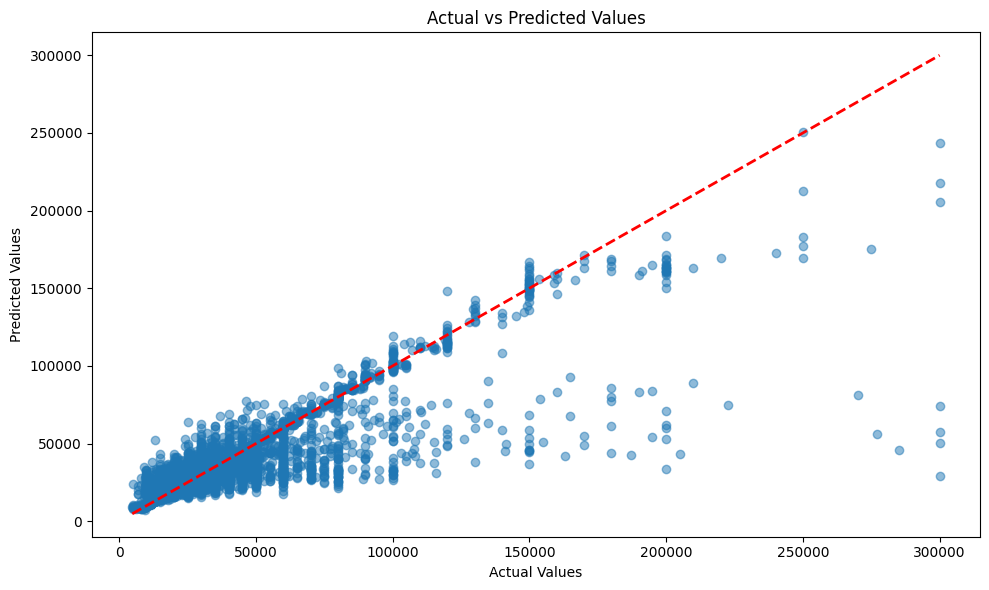

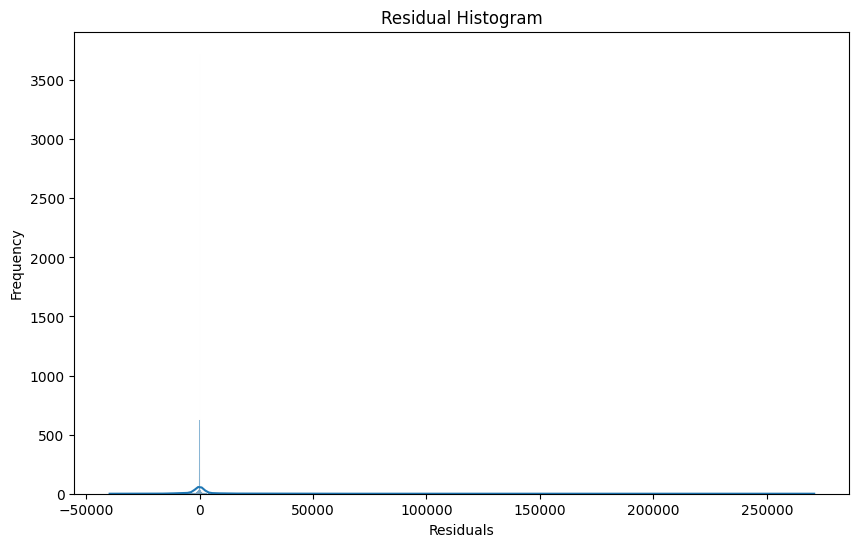

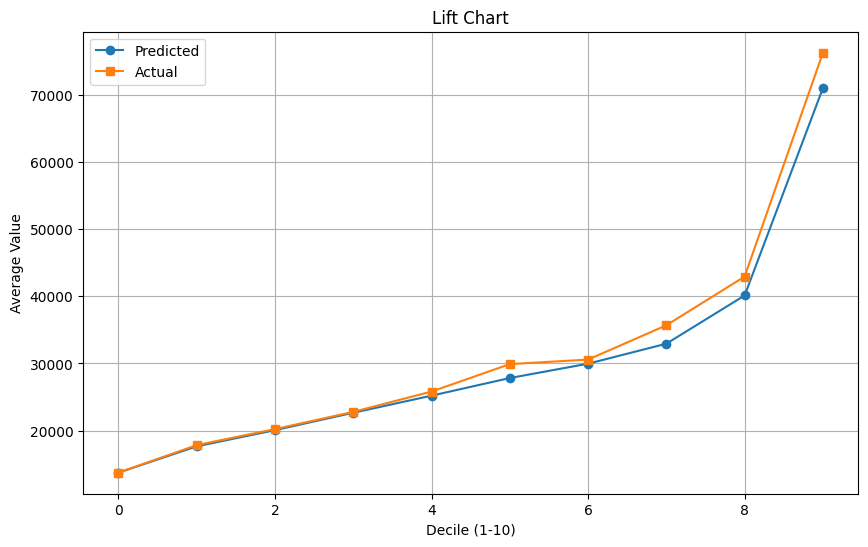

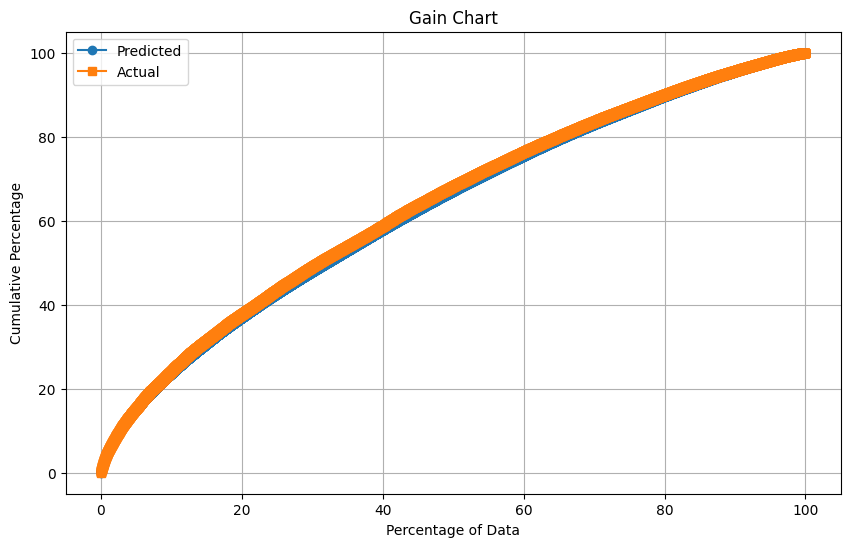


Top 10 Most Important Features:
                               feature  importance
0           encoded_company_name_group   65.667085
1                    loan_product_type    8.303457
2                 loan_education_level    3.826559
3                 industry_description    2.774798
4                        osversionType    1.991358
5                                  age    1.923566
6                      employment_type    1.692745
7                 CreditAvgCreditLimit    1.309565
8             max_amt_active_contracts    1.272817
9                           loan_brand    1.192535
10                           loan_city    0.970479
11                        loan_docType    0.572914
12              nature_of_work_grouped    0.563621
13                     loan_postalcode    0.538274
14                        loan_purpose    0.459531
15                     dependentsCount    0.382376
16  Credit_Cards_active_contracts_util    0.379170
17              Onboarding_mon_of_year    0.34072

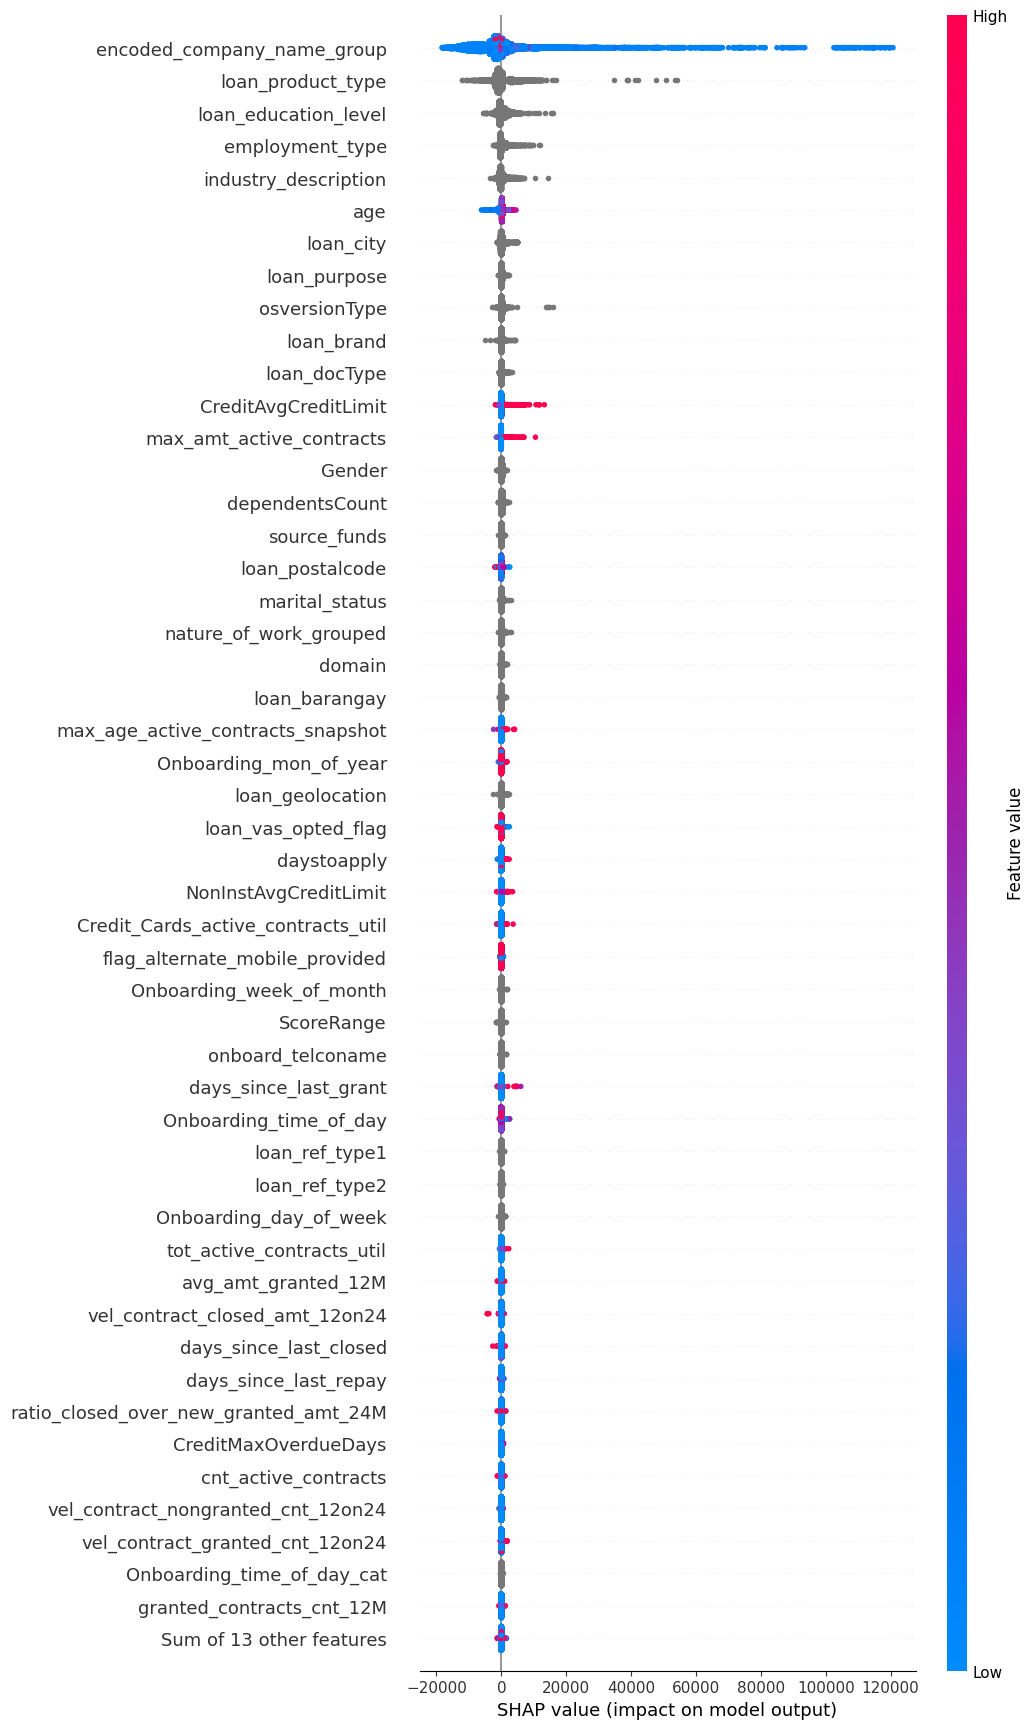

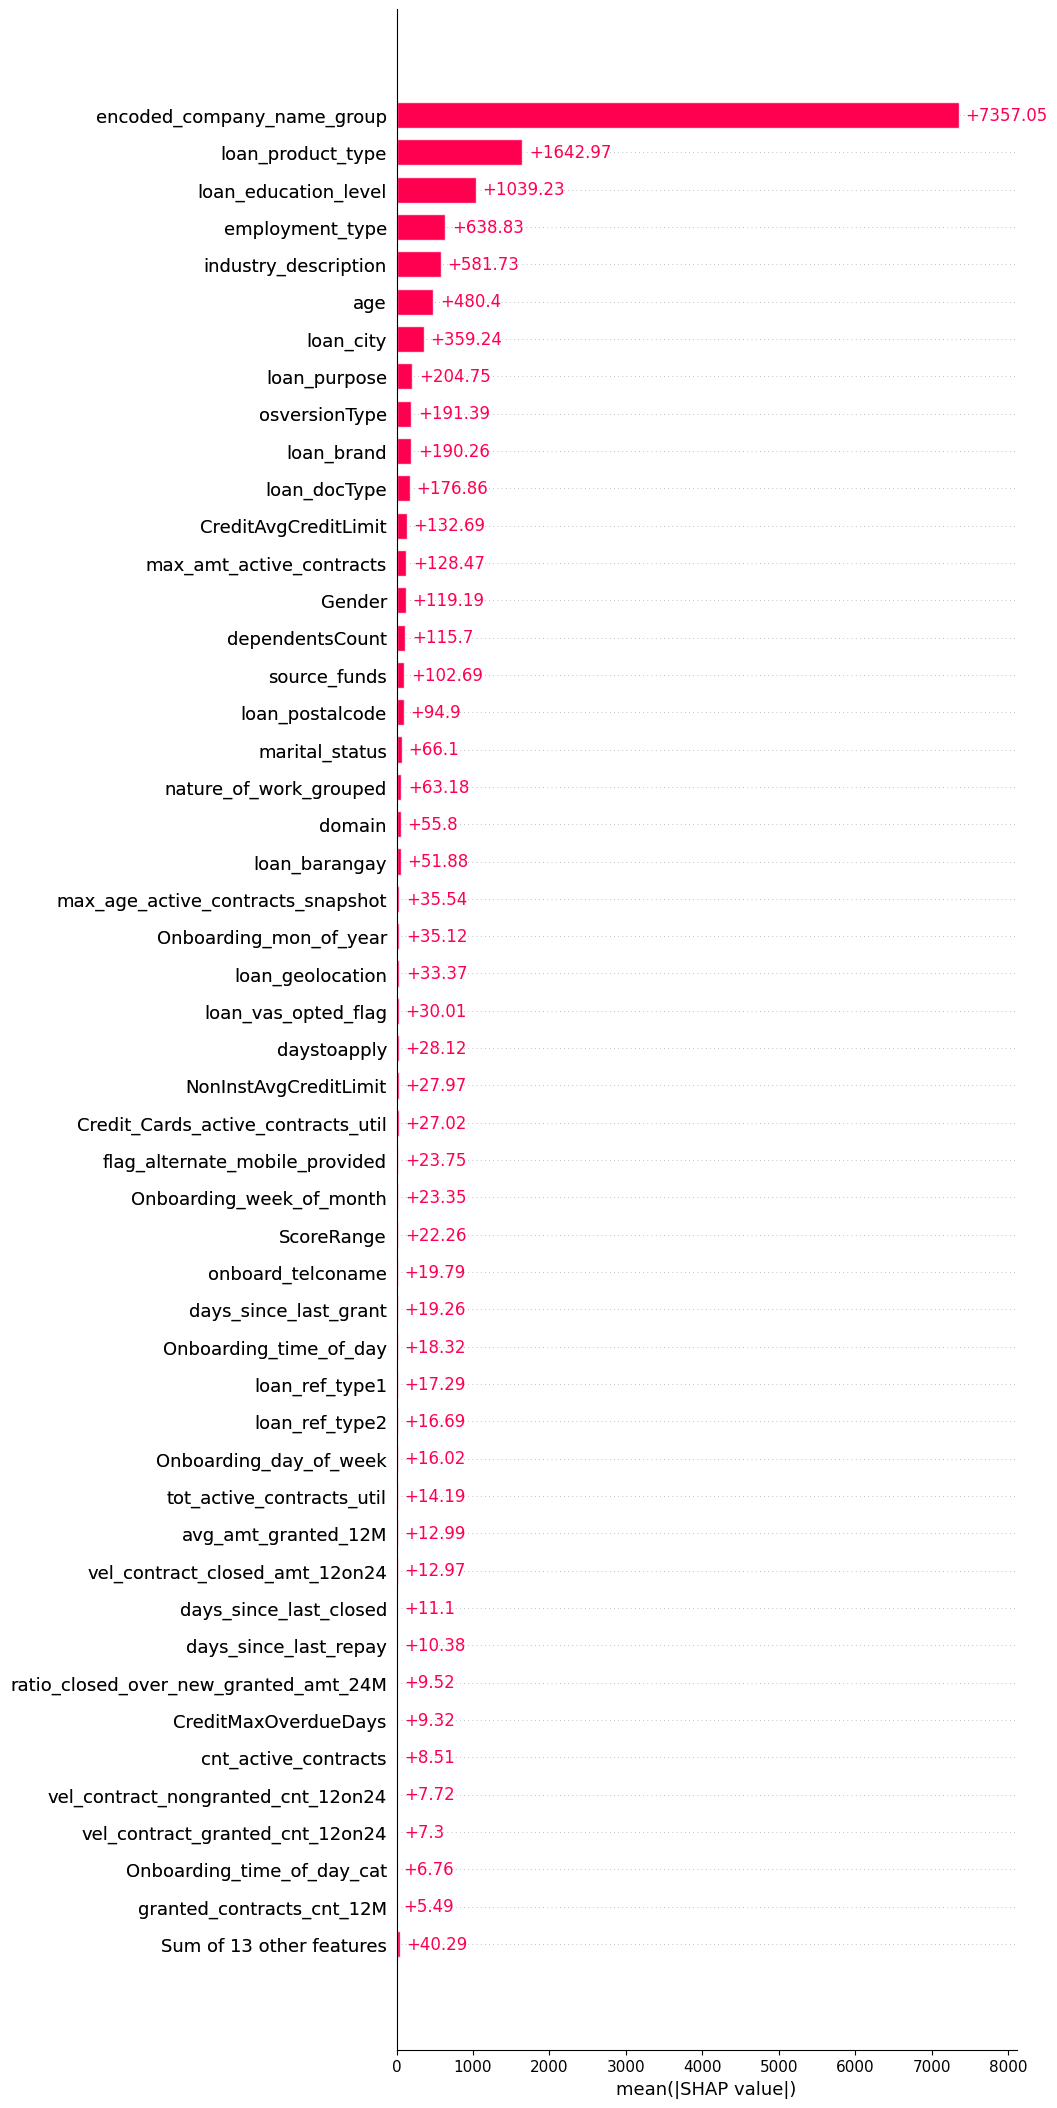

Top Ten Shap features:/t                        feature  shap_importance
14  encoded_company_name_group      7357.047919
51           loan_product_type      1642.967061
49        loan_education_level      1039.234119
43             employment_type       638.829429
44        industry_description       581.725274
4                          age       480.401574
47                   loan_city       359.238069
52                loan_purpose       204.754193
58               osversionType       191.389468
46                  loan_brand       190.256614
48                loan_docType       176.864470
0         CreditAvgCreditLimit       132.693616
20    max_amt_active_contracts       128.468750
33                      Gender       119.187735
41             dependentsCount       115.703440
59                source_funds       102.687099
17             loan_postalcode        94.897280
55              marital_status        66.097998
56      nature_of_work_grouped        63.182220
42             

In [52]:
columns_to_exclude = ['cust_id', 'digitalLoanAccountId', 'onboarding_datetime','document_valid_flag',
                     'mothersMaidenFullName', 'loan_company_name', 'email', 'text__company_and_industry', 
                     'onb_latitude', 'onb_longitude', 'user_type', 'loan_docNumber', 'Dataselection',
                     'loanAccountNumber', 'text__cluster', 'onb_city', 'loan_province', 'loan_type',
                     'freq_encodedcompanyName', 'onb_PermanentAddress', 'target_encodedcompanyName',
                     'datetime__Onboarding_week_of_month', 'datetime__Onboarding_day_of_week','loan_mobile_no',
                     'datetime__Onboarding_mon_of_year']

results = Custom_Catboost_Model(df, 'loan_monthly_income', threshold=0.8, columns_to_exclude=columns_to_exclude)
results_Good_customer = results.copy()
# Access results
model = results['model']
metrics = results['metrics']
feature_importance = results['feature_importance']
predictions = results['predictions']
X_train_data = results['X_train']
X_test_data = results['X_test']
y_train_data = results['y_train']
y_test_data = results['y_test']
numerical_cols = results['numerical_cols']
categorical_cols = results['categorical_cols']
top_ten_shap_features = results['top_ten_shap_features']
result_df = results['result_df']

print(f"Top Ten Shap features:/t {top_ten_shap_features}")

## Save the model joblib file - model_Good_Customer_Alpha

In [53]:
import os
import joblib
from catboost import CatBoostRegressor, CatBoostClassifier  # Import both classes

def save_model(model, save_dir, file_name):
    """
    Save a CatBoost model to disk with proper validation and error handling.
    
    Parameters:
    -----------
    model : CatBoostRegressor or CatBoostClassifier
        The trained CatBoost model to save
    save_dir : str
        Directory path where the model should be saved
    file_name : str
        Name of the file to save the model as
        
    Returns:
    --------
    bool
        True if save successful, False otherwise
    """
    # Validate model type
    if not isinstance(model, (CatBoostRegressor, CatBoostClassifier)):
        raise TypeError("Model must be a CatBoost model")
    
    # Clean and validate the path
    save_dir = os.path.expanduser(save_dir)  # Expand user directory if present
    save_dir = os.path.abspath(save_dir)     # Convert to absolute path
    
    # Create full path
    full_path = os.path.join(save_dir, file_name)
    
    try:
        # Create directory if it doesn't exist
        os.makedirs(save_dir, exist_ok=True)
        
        # Verify write permissions
        if not os.access(save_dir, os.W_OK):
            raise PermissionError(f"No write permission for directory: {save_dir}")
            
        # Save the model
        joblib.dump(model, full_path)
        
        # Verify file was created
        if os.path.exists(full_path):
            print(f"Model successfully saved to: {full_path}")
            return True
        else:
            print("File was not created successfully")
            return False
            
    except Exception as e:
        print(f"Error saving model: {str(e)}")
        return False

In [54]:
modeloverallfilename = f"{MODELNAME}_{PRODUCT_TYPE}_{VERSIONNAME}_model_good_customer_{DATATYPE}.joblib"
destination_blob_name = f"{CLOUDPATH}/{modeloverallfilename}"
save_model(model,  f"{LOCALPATH}", f"{modeloverallfilename}")
print(f"The model is saved at {CLOUDPATH}/{modeloverallfilename}")

Model successfully saved to: /home/jupyter/Models/Income_Estimation_Alpha/Alpha_SIL_Quick_1_0_model_good_customer_Step.joblib
The model is saved at Monthly_Income_Estimation/Income_Estimation_Alpha/Data/Alpha_SIL_Quick_1_0_model_good_customer_Step.joblib


In [55]:
RESULTFILENAME = f"result_df_{MODELNAME}_{PRODUCT_TYPE}_{VERSIONNAME}_model_good_customer_{DATATYPE}"
result_df.to_csv(f"{LOCALPATH}/{RESULTFILENAME}.csv")
print(f"The result df is saved at {LOCALPATH}/{RESULTFILENAME}")

numcoldf = pd.DataFrame(numerical_cols, columns=['numerical_cols'])
numfilename = f"numerical_cols{MODELNAME}_{DATATYPE}_{VERSIONNAME}"
numcoldf.to_csv(f"{LOCALPATH}/{numfilename}.csv")

catcoldf = pd.DataFrame(categorical_cols, columns=['categorical_cols'])
catfilename = f"categorical_cols{MODELNAME}_{DATATYPE}_{VERSIONNAME}"
catcoldf.to_csv(f"{LOCALPATH}/{catfilename}.csv")

topshapdf = pd.DataFrame(top_ten_shap_features, columns=['Top_Ten_Features'])
topshapfilename = f"Top_Ten_Features{MODELNAME}_{DATATYPE}_{VERSIONNAME}"
topshapdf.to_csv(f"{LOCALPATH}/{topshapfilename}.csv")

The result df is saved at /home/jupyter/Models/Income_Estimation_Alpha//result_df_Alpha_SIL_Quick_1_0_model_good_customer_Step


In [56]:
# Serialize the model using joblib
joblib.dump(model, f"{MODELNAME}_{PRODUCT_TYPE}_{VERSIONNAME}_model_good_customer_{DATATYPE}.joblib")

# Upload to Google Cloud Storage
client = storage.Client()
bucket_name = BUCKET_NAME
source_file_name = f"{MODELNAME}_{PRODUCT_TYPE}_{VERSIONNAME}_model_good_customer_{DATATYPE}.joblib"
destination_blob_name = f"{CLOUDPATH}/{MODELNAME}_{PRODUCT_TYPE}_{VERSIONNAME}_model_good_customer_{DATATYPE}.joblib"

bucket = client.bucket(bucket_name)
blob = bucket.blob(destination_blob_name)
blob.upload_from_filename(source_file_name)

In [57]:
# After model training
import joblib

# Save the complete state
state = {
    'random_state': 42,
    'model': model,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'X_train_shape': X_train_data.shape,
    'X_test_shape': X_test_data.shape
}
joblib.dump(state, f"{MODELNAME}_{PRODUCT_TYPE}_{VERSIONNAME}_model_good_customer_state_{DATATYPE}.joblib")

['Alpha_SIL_Quick_1_0_model_good_customer_state_Step.joblib']

## Calling the Model state back to check

In [58]:
filepath = f"{MODELNAME}_{PRODUCT_TYPE}_{VERSIONNAME}_model_good_customer_state_{DATATYPE}.joblib"
loaded_state = joblib.load(filepath)  # Use the same filepath

loaded_model = loaded_state['model']
numerical_cols = loaded_state['numerical_cols']
categorical_cols = loaded_state['categorical_cols']
# metadata = loaded_state['metadata']  # Access metadata

# Now you can use loaded_model, numerical_cols, and categorical_cols
# to make predictions on new data.
print(numerical_cols)
print(categorical_cols)

['CreditAvgCreditLimit', 'CreditMaxOverdueDays', 'Credit_Cards_active_contracts_util', 'NonInstAvgCreditLimit', 'age', 'avg_amt_granted_12M', 'avg_days_bw_contracts_12m', 'avg_no_of_installments_12M', 'cnt_active_contracts', 'cnt_active_contracts_Credit_Cards', 'days_since_last_closed', 'days_since_last_grant', 'days_since_last_repay', 'daystoapply', 'encoded_company_name_group', 'flag_alternate_mobile_provided', 'granted_contracts_cnt_12M', 'loan_postalcode', 'loan_vas_opted_flag', 'max_age_active_contracts_snapshot', 'max_amt_active_contracts', 'onb_mobile_Not_match_loan_mobile', 'ratio_closed_over_new_granted_amt_12M', 'ratio_closed_over_new_granted_amt_24M', 'ratio_closed_over_new_granted_cnt_12M', 'ratio_closed_over_new_granted_cnt_24M', 'tot_active_contracts_util', 'vel_contract_closed_amt_12on24', 'vel_contract_granted_amt_12on24', 'vel_contract_granted_amt_6on12', 'vel_contract_granted_cnt_12on24', 'vel_contract_granted_cnt_6on12', 'vel_contract_nongranted_cnt_12on24']
['Gender

# Model with only top 20 SHAP features 

The top 20 features are:	['loan_product_type', 'loan_education_level', 'employment_type', 'industry_description', 'age', 'loan_city', 'loan_purpose', 'osversionType', 'loan_brand', 'loan_docType', 'CreditAvgCreditLimit', 'max_amt_active_contracts', 'Gender', 'dependentsCount', 'source_funds', 'loan_postalcode', 'marital_status', 'nature_of_work_grouped', 'domain']
Data downloaded from Monthly_Income_Estimation/Target_Encoded_Artifacts/companytrgencode.joblib
Index(['global_mean', 'smoothing_factor', 'loan_company_name',
       'freq_encodedcompanyName', 'category_mean_companyName',
       'category_size_companyName', 'target_encodedcompanyName',
       'encoded_company_name_group'],
      dtype='object')
Preparing data...
The shape of dfcn before duplicate drop is:	 (61616, 4)
The shape of dfcn is:	 (61616, 4)
The shape of df_train is:	(61584, 25)
['digitalLoanAccountId', 'freq_encodedcompanyName', 'target_encodedcompanyName', 'loan_company_name', 'loan_type']
Dropped columns due to mu

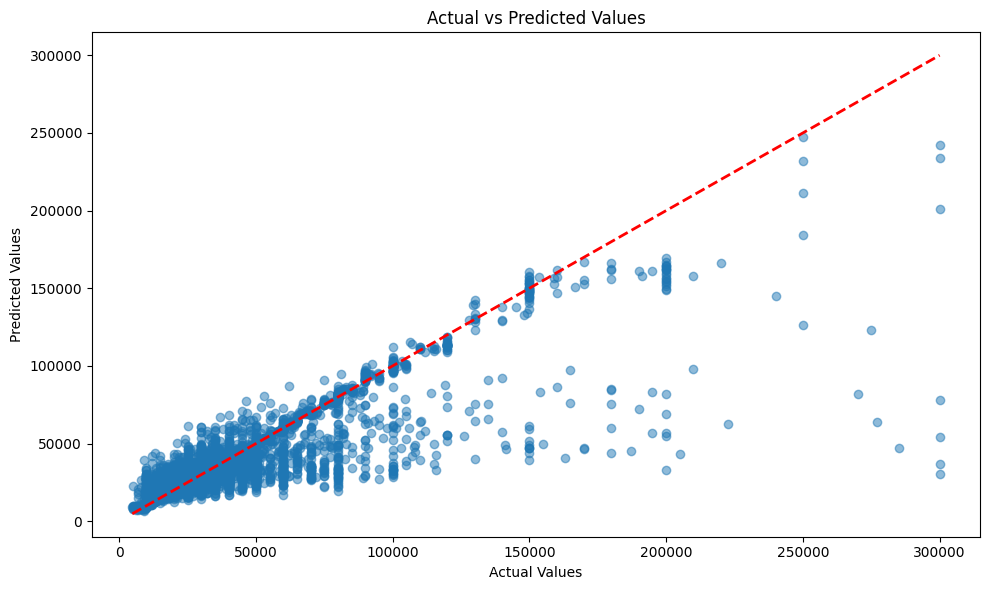

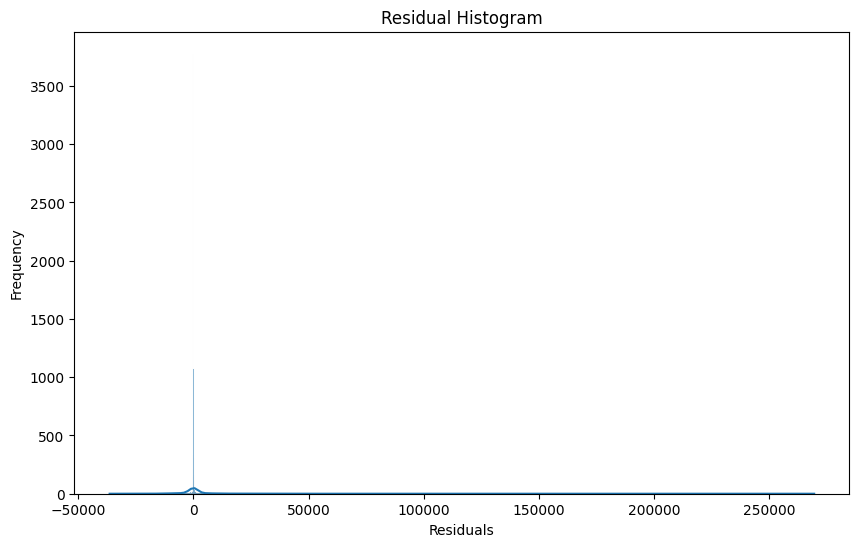

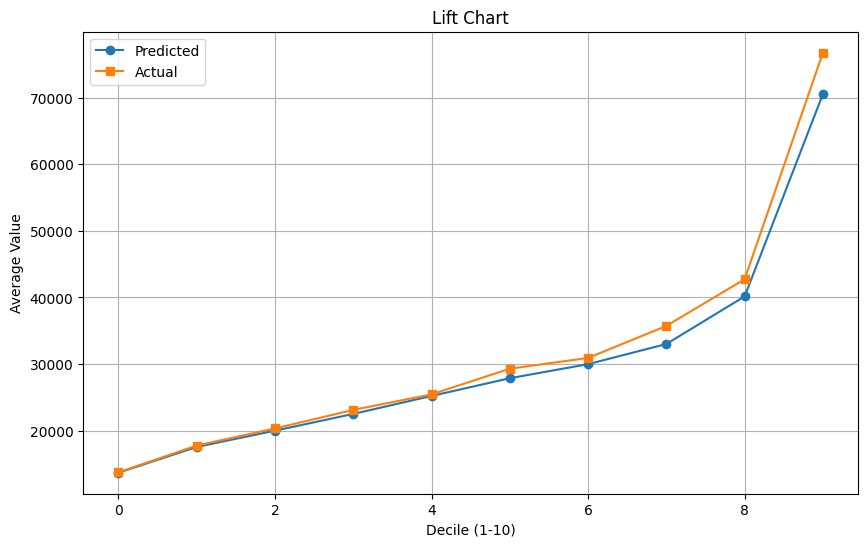

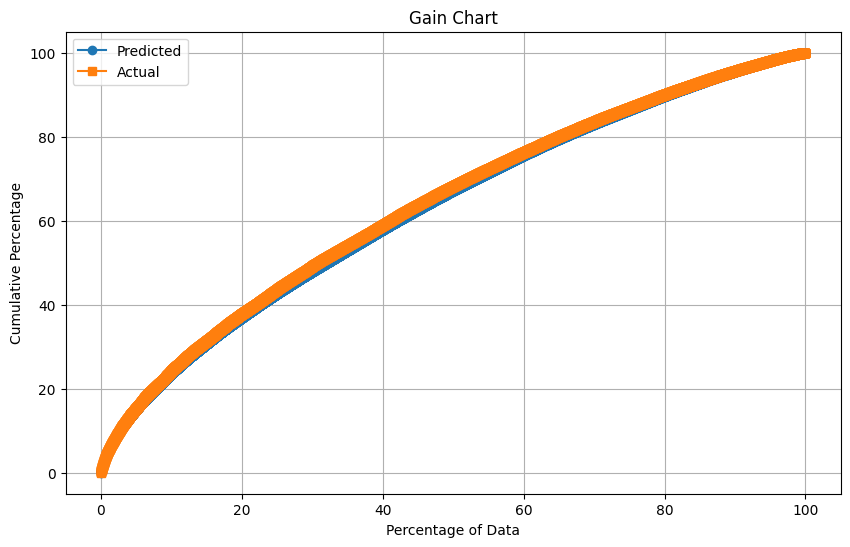


Top 10 Most Important Features:
                       feature  importance
0   encoded_company_name_group   68.422329
1            loan_product_type    8.305967
2         loan_education_level    4.785652
3         industry_description    2.571333
4              employment_type    2.432511
5                          age    2.267895
6     max_amt_active_contracts    2.107175
7                osversionType    1.615826
8         CreditAvgCreditLimit    1.612572
9                    loan_city    1.162484
10      nature_of_work_grouped    0.845812
11                  loan_brand    0.775036
12                loan_purpose    0.611093
13             loan_postalcode    0.545688
14                source_funds    0.391009
15                loan_docType    0.368507
16             dependentsCount    0.312670
17                      Gender    0.299056
18                      domain    0.296773
19              marital_status    0.270611


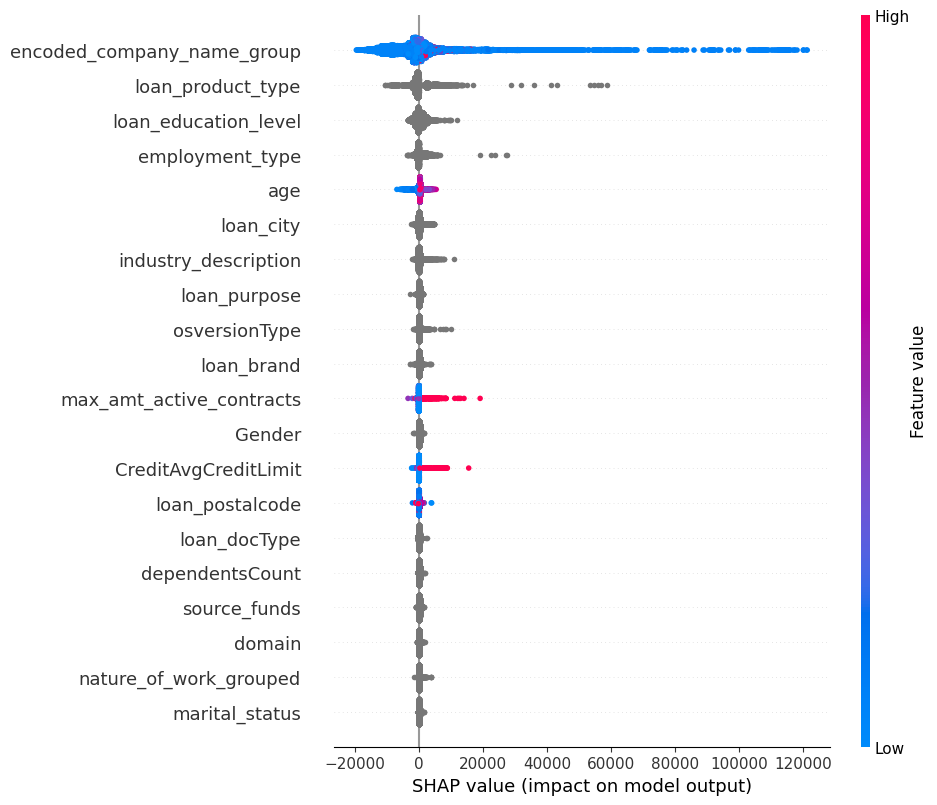

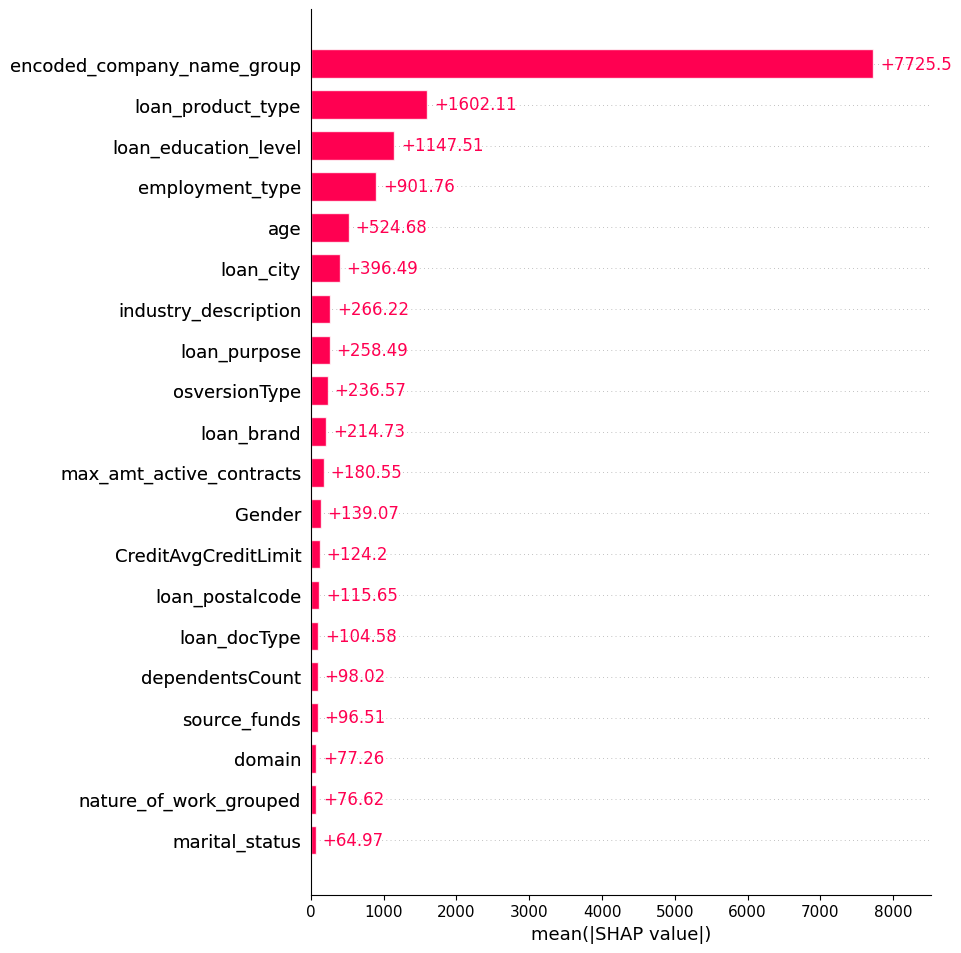

                       feature  shap_importance
2   encoded_company_name_group      7725.503800
14           loan_product_type      1602.113461
13        loan_education_level      1147.507931
8              employment_type       901.762044
1                          age       524.679264
11                   loan_city       396.490706
9         industry_description       266.217046
15                loan_purpose       258.486956
18               osversionType       236.569301
10                  loan_brand       214.731562
4     max_amt_active_contracts       180.550255
5                       Gender       139.065281
0         CreditAvgCreditLimit       124.204854
3              loan_postalcode       115.652329
12                loan_docType       104.583817
6              dependentsCount        98.020457
19                source_funds        96.512387
7                       domain        77.264926
17      nature_of_work_grouped        76.620490
16              marital_status        64

In [59]:
# Sort the features by importance in descending order
feature_importance_sorted = top_ten_shap_features.sort_values(by='shap_importance', ascending=False)
# print(feature_importance_sorted)
# Get the top 20 features
top_20_features = feature_importance_sorted['feature'].head(20).tolist()
top_20_features.remove('encoded_company_name_group')
print(f"The top 20 features are:\t{top_20_features}")
# Subset the DataFrame to include only the top 20 features, the target variable, and 'Dataselection'
top_20_features_with_target = top_20_features + ['digitalLoanAccountId','loan_monthly_income', 'Dataselection', 'loan_company_name']
df_subset = df[top_20_features_with_target]

df_subset.head()

df_subset.groupby('Dataselection')['digitalLoanAccountId'].nunique()

df_Good_Customer_Top20features = df_subset.copy()
df_Good_Customer_Top20features.columns

### model_Good_Customer_Top 20 SHAP_Features_Beta1V4_0

# Define your columns to exclude (optional, there's a default list in the function)
columns_to_exclude = ['digitalLoanAccountId','freq_encodedcompanyName','target_encodedcompanyName','loan_company_name', 'loan_type']

# Run the model
results = Custom_Catboost_Model(df_Good_Customer_Top20features, 'loan_monthly_income', threshold=0.8, columns_to_exclude=columns_to_exclude)

# Access results
model_top20SHAP = results['model']
metrics_top20SHAP = results['metrics']
feature_importance_top20SHAP = results['feature_importance']
predictions_top20SHAP = results['predictions']
X_train_top20SHAP = results['X_train']
X_test_top20SHAP = results['X_test']
y_train_top20SHAP = results['y_train']
y_test_top20SHAP = results['y_test']
numerical_cols_top20SHAP = results['numerical_cols']
categorical_cols_top20SHAP = results['categorical_cols']
top_ten_shap_features_top20SHAP = results['top_ten_shap_features']
result_df_Top20SHAP = results['result_df']

print(top_ten_shap_features_top20SHAP)

## Save the model joblib file - model_Good_Customer_Top20SHAPFeatures_Beta1V3_Step2

MODELTOP20FILENAME = f"model_Good_Customer_Top20SHAPFeatures_{MODELNAME}_{DATATYPE}_{VERSIONNAME}.joblib"
print(MODELTOP20FILENAME)
destination_blob_name = f"{CLOUDPATH}/{MODELTOP20FILENAME}"
save_model(model_top20SHAP,  f"{LOCALPATH}", f"{MODELTOP20FILENAME}")

result_filename = f"result_df_Top20SHAP_{MODELNAME}_{DATATYPE}_{VERSIONNAME}"
result_df_Top20SHAP.to_csv(f"{LOCALPATH}/{result_filename}.csv")

numcoldf = pd.DataFrame(numerical_cols_top20SHAP, columns=['numerical_cols_top20SHAP'])
numfilename = f"Numericalcols_Top20SHAP_{MODELNAME}_{DATATYPE}_{VERSIONNAME}"
numcoldf.to_csv(f"{LOCALPATH}/{numfilename}.csv")

catcoldf = pd.DataFrame(categorical_cols_top20SHAP, columns=['categorical_cols_top20SHAP'])
catfilename = f"Categorical_cols_top20SHAPP_{MODELNAME}_{DATATYPE}_{VERSIONNAME}"
catcoldf.to_csv(f"{LOCALPATH}/{catfilename}.csv")

topshapdf = pd.DataFrame(top_ten_shap_features_top20SHAP, columns=['top_ten_shap_features_top20SHAP'])
topshapfilename = f"top_ten_shap_features_top20SHAP{MODELNAME}_{DATATYPE}_{VERSIONNAME}"
topshapdf.to_csv(f"{LOCALPATH}/{topshapfilename}.csv")

# Serialize the model using joblib
joblib.dump(model_top20SHAP, f'{MODELTOP20FILENAME}')

# Upload to Google Cloud Storage
client = storage.Client()
bucket_name = BUCKET_NAME
source_file_name = MODELTOP20FILENAME
destination_blob_name = f"{CLOUDPATH}/{MODELTOP20FILENAME}"

bucket = client.bucket(bucket_name)
blob = bucket.blob(destination_blob_name)
blob.upload_from_filename(source_file_name)



In [60]:
# After model training
import joblib

# Save the complete state
state_top20SHAP = {
    'random_state': 42,
    'model_top20SHAP': model_top20SHAP,
    'numerical_cols_top20SHAP': numerical_cols_top20SHAP,
    'categorical_cols_top20SHAP': categorical_cols_top20SHAP,
    'X_train_top20SHAP_shape': X_train_top20SHAP.shape,
    'X_test_top20SHAP_shape': X_test_top20SHAP.shape
}
joblib.dump(state_top20SHAP, f"{MODELNAME}_{PRODUCT_TYPE}_{VERSIONNAME}_model_good_customer_state_top20SHAP_{DATATYPE}.joblib")

['Alpha_SIL_Quick_1_0_model_good_customer_state_top20SHAP_Step.joblib']

## Calling the Model state back to check

In [61]:
filepath = f"{MODELNAME}_{PRODUCT_TYPE}_{VERSIONNAME}_model_good_customer_state_top20SHAP_{DATATYPE}.joblib"
loaded_state = joblib.load(filepath)  # Use the same filepath

loaded_model = loaded_state['model_top20SHAP']
numerical_cols = loaded_state['numerical_cols_top20SHAP']
categorical_cols = loaded_state['categorical_cols_top20SHAP']
# metadata = loaded_state['metadata']  # Access metadata

# Now you can use loaded_model, numerical_cols, and categorical_cols
# to make predictions on new data.
print(numerical_cols)
print(categorical_cols)

['CreditAvgCreditLimit', 'age', 'encoded_company_name_group', 'loan_postalcode', 'max_amt_active_contracts']
['Gender', 'dependentsCount', 'domain', 'employment_type', 'industry_description', 'loan_brand', 'loan_city', 'loan_docType', 'loan_education_level', 'loan_product_type', 'loan_purpose', 'marital_status', 'nature_of_work_grouped', 'osversionType', 'source_funds']


# Model with only top 19 SHAP features 

In [ ]:
# Sort the features by importance in descending order
feature_importance_sorted = top_ten_shap_features.sort_values(by='shap_importance', ascending=False)
# print(feature_importance_sorted)
# Get the top 19 features
top_19_features = feature_importance_sorted['feature'].head(19).tolist()
top_19_features.remove('encoded_company_name_group')
print(f"The top 19 features are:\t{top_19_features}")
# Subset the DataFrame to include only the top 19 features, the target variable, and 'Dataselection'
top_19_features_with_target = top_19_features + ['digitalLoanAccountId','loan_monthly_income', 'Dataselection', 'loan_company_name']
df_subset = df[top_19_features_with_target]

df_subset.head()

df_subset.groupby('Dataselection')['digitalLoanAccountId'].nunique()

df_Good_Customer_Top19features = df_subset.copy()
df_Good_Customer_Top19features.columns

### model_Good_Customer_Top 19 SHAP_Features_Beta1V4_0

# Define your columns to exclude (optional, there's a default list in the function)
columns_to_exclude = ['digitalLoanAccountId','freq_encodedcompanyName','target_encodedcompanyName','loan_company_name', 'loan_type']

# Run the model
results = Custom_Catboost_Model(df_Good_Customer_Top19features, 'loan_monthly_income', threshold=0.8, columns_to_exclude=columns_to_exclude)

# Access results
model_top19SHAP = results['model']
metrics_top19SHAP = results['metrics']
feature_importance_top19SHAP = results['feature_importance']
predictions_top19SHAP = results['predictions']
X_train_top19SHAP = results['X_train']
X_test_top19SHAP = results['X_test']
y_train_top19SHAP = results['y_train']
y_test_top19SHAP = results['y_test']
numerical_cols_top19SHAP = results['numerical_cols']
categorical_cols_top19SHAP = results['categorical_cols']
top_ten_shap_features_top19SHAP = results['top_ten_shap_features']
result_df_Top19SHAP = results['result_df']

print(top_ten_shap_features_top19SHAP)

## Save the model joblib file - model_Good_Customer_Top19SHAPFeatures_Beta1V3_Step2

MODELTOP19FILENAME = f"model_Good_Customer_Top19SHAPFeatures_{MODELNAME}_{DATATYPE}_{VERSIONNAME}.joblib"
print(MODELTOP19FILENAME)
destination_blob_name = f"{CLOUDPATH}/{MODELTOP19FILENAME}"
save_model(model_top19SHAP,  f"{LOCALPATH}", f"{MODELTOP19FILENAME}")

result_filename = f"result_df_Top19SHAP_{MODELNAME}_{DATATYPE}_{VERSIONNAME}"
result_df_Top19SHAP.to_csv(f"{LOCALPATH}/{result_filename}.csv")

numcoldf = pd.DataFrame(numerical_cols_top19SHAP, columns=['numerical_cols_top19SHAP'])
numfilename = f"Numericalcols_Top19SHAP_{MODELNAME}_{DATATYPE}_{VERSIONNAME}"
numcoldf.to_csv(f"{LOCALPATH}/{numfilename}.csv")

catcoldf = pd.DataFrame(categorical_cols_top19SHAP, columns=['categorical_cols_top19SHAP'])
catfilename = f"Categorical_cols_top19SHAPP_{MODELNAME}_{DATATYPE}_{VERSIONNAME}"
catcoldf.to_csv(f"{LOCALPATH}/{catfilename}.csv")

topshapdf = pd.DataFrame(top_ten_shap_features_top19SHAP, columns=['top_ten_shap_features_top19SHAP'])
topshapfilename = f"top_ten_shap_features_top19SHAP{MODELNAME}_{DATATYPE}_{VERSIONNAME}"
topshapdf.to_csv(f"{LOCALPATH}/{topshapfilename}.csv")

# Serialize the model using joblib
joblib.dump(model_top19SHAP, f'{MODELTOP19FILENAME}')

# Upload to Google Cloud Storage
client = storage.Client()
bucket_name = BUCKET_NAME
source_file_name = MODELTOP19FILENAME
destination_blob_name = f"{CLOUDPATH}/{MODELTOP19FILENAME}"

bucket = client.bucket(bucket_name)
blob = bucket.blob(destination_blob_name)
blob.upload_from_filename(source_file_name)



The top 19 features are:	['loan_product_type', 'loan_education_level', 'employment_type', 'industry_description', 'age', 'loan_city', 'loan_purpose', 'osversionType', 'loan_brand', 'loan_docType', 'CreditAvgCreditLimit', 'max_amt_active_contracts', 'Gender', 'dependentsCount', 'source_funds', 'loan_postalcode', 'marital_status', 'nature_of_work_grouped']
Data downloaded from Monthly_Income_Estimation/Target_Encoded_Artifacts/companytrgencode.joblib
Index(['global_mean', 'smoothing_factor', 'loan_company_name',
       'freq_encodedcompanyName', 'category_mean_companyName',
       'category_size_companyName', 'target_encodedcompanyName',
       'encoded_company_name_group'],
      dtype='object')
Preparing data...
The shape of dfcn before duplicate drop is:	 (61616, 4)
The shape of dfcn is:	 (61616, 4)
The shape of df_train is:	(61584, 24)
['digitalLoanAccountId', 'freq_encodedcompanyName', 'target_encodedcompanyName', 'loan_company_name', 'loan_type']
Dropped columns due to multicolline

In [ ]:
# After model training
import joblib

# Save the complete state
state_top19SHAP = {
    'random_state': 42,
    'model_top19SHAP': model_top19SHAP,
    'numerical_cols_top19SHAP': numerical_cols_top19SHAP,
    'categorical_cols_top19SHAP': categorical_cols_top19SHAP,
    'X_train_top19SHAP_shape': X_train_top19SHAP.shape,
    'X_test_top19SHAP_shape': X_test_top19SHAP.shape
}
joblib.dump(state_top19SHAP, f"{MODELNAME}_{PRODUCT_TYPE}_{VERSIONNAME}_model_good_customer_state_top19SHAP_{DATATYPE}.joblib")

## Calling the Model state back to check

In [ ]:
filepath = f"{MODELNAME}_{PRODUCT_TYPE}_{VERSIONNAME}_model_good_customer_state_top19SHAP_{DATATYPE}.joblib"
loaded_state = joblib.load(filepath)  # Use the same filepath

loaded_model = loaded_state['model_top19SHAP']
numerical_cols = loaded_state['numerical_cols_top19SHAP']
categorical_cols = loaded_state['categorical_cols_top19SHAP']
# metadata = loaded_state['metadata']  # Access metadata

# Now you can use loaded_model, numerical_cols, and categorical_cols
# to make predictions on new data.
print(numerical_cols)
print(categorical_cols)

# Model with only top 18 SHAP features 

In [ ]:
# Sort the features by importance in descending order
feature_importance_sorted = top_ten_shap_features.sort_values(by='shap_importance', ascending=False)
# print(feature_importance_sorted)
# Get the top 18 features
top_18_features = feature_importance_sorted['feature'].head(18).tolist()
top_18_features.remove('encoded_company_name_group')
print(f"The top 18 features are:\t{top_18_features}")
# Subset the DataFrame to include only the top 18 features, the target variable, and 'Dataselection'
top_18_features_with_target = top_18_features + ['digitalLoanAccountId','loan_monthly_income', 'Dataselection', 'loan_company_name']
df_subset = df[top_18_features_with_target]

df_subset.head()

df_subset.groupby('Dataselection')['digitalLoanAccountId'].nunique()

df_Good_Customer_Top18features = df_subset.copy()
df_Good_Customer_Top18features.columns

### model_Good_Customer_Top 18 SHAP_Features_Beta1V4_0

# Define your columns to exclude (optional, there's a default list in the function)
columns_to_exclude = ['digitalLoanAccountId','freq_encodedcompanyName','target_encodedcompanyName','loan_company_name', 'loan_type']

# Run the model
results = Custom_Catboost_Model(df_Good_Customer_Top18features, 'loan_monthly_income', threshold=0.8, columns_to_exclude=columns_to_exclude)

# Access results
model_top18SHAP = results['model']
metrics_top18SHAP = results['metrics']
feature_importance_top18SHAP = results['feature_importance']
predictions_top18SHAP = results['predictions']
X_train_top18SHAP = results['X_train']
X_test_top18SHAP = results['X_test']
y_train_top18SHAP = results['y_train']
y_test_top18SHAP = results['y_test']
numerical_cols_top18SHAP = results['numerical_cols']
categorical_cols_top18SHAP = results['categorical_cols']
top_ten_shap_features_top18SHAP = results['top_ten_shap_features']
result_df_Top18SHAP = results['result_df']

print(top_ten_shap_features_top18SHAP)

## Save the model joblib file - model_Good_Customer_Top18SHAPFeatures_Beta1V3_Step2

MODELTOP18FILENAME = f"model_Good_Customer_Top18SHAPFeatures_{MODELNAME}_{DATATYPE}_{VERSIONNAME}.joblib"
print(MODELTOP18FILENAME)
destination_blob_name = f"{CLOUDPATH}/{MODELTOP18FILENAME}"
save_model(model_top18SHAP,  f"{LOCALPATH}", f"{MODELTOP18FILENAME}")

result_filename = f"result_df_Top18SHAP_{MODELNAME}_{DATATYPE}_{VERSIONNAME}"
result_df_Top18SHAP.to_csv(f"{LOCALPATH}/{result_filename}.csv")

numcoldf = pd.DataFrame(numerical_cols_top18SHAP, columns=['numerical_cols_top18SHAP'])
numfilename = f"Numericalcols_Top18SHAP_{MODELNAME}_{DATATYPE}_{VERSIONNAME}"
numcoldf.to_csv(f"{LOCALPATH}/{numfilename}.csv")

catcoldf = pd.DataFrame(categorical_cols_top18SHAP, columns=['categorical_cols_top18SHAP'])
catfilename = f"Categorical_cols_top18SHAPP_{MODELNAME}_{DATATYPE}_{VERSIONNAME}"
catcoldf.to_csv(f"{LOCALPATH}/{catfilename}.csv")

topshapdf = pd.DataFrame(top_ten_shap_features_top18SHAP, columns=['top_ten_shap_features_top18SHAP'])
topshapfilename = f"top_ten_shap_features_top18SHAP{MODELNAME}_{DATATYPE}_{VERSIONNAME}"
topshapdf.to_csv(f"{LOCALPATH}/{topshapfilename}.csv")

# Serialize the model using joblib
joblib.dump(model_top18SHAP, f'{MODELTOP18FILENAME}')

# Upload to Google Cloud Storage
client = storage.Client()
bucket_name = BUCKET_NAME
source_file_name = MODELTOP18FILENAME
destination_blob_name = f"{CLOUDPATH}/{MODELTOP18FILENAME}"

bucket = client.bucket(bucket_name)
blob = bucket.blob(destination_blob_name)
blob.upload_from_filename(source_file_name)



In [ ]:
# After model training
import joblib

# Save the complete state
state_top18SHAP = {
    'random_state': 42,
    'model_top18SHAP': model_top18SHAP,
    'numerical_cols_top18SHAP': numerical_cols_top18SHAP,
    'categorical_cols_top18SHAP': categorical_cols_top18SHAP,
    'X_train_top18SHAP_shape': X_train_top18SHAP.shape,
    'X_test_top18SHAP_shape': X_test_top18SHAP.shape
}
joblib.dump(state_top18SHAP, f"{MODELNAME}_{PRODUCT_TYPE}_{VERSIONNAME}_model_good_customer_state_top18SHAP_{DATATYPE}.joblib")

## Calling the Model state back to check

In [ ]:
filepath = f"{MODELNAME}_{PRODUCT_TYPE}_{VERSIONNAME}_model_good_customer_state_top18SHAP_{DATATYPE}.joblib"
loaded_state = joblib.load(filepath)  # Use the same filepath

loaded_model = loaded_state['model_top18SHAP']
numerical_cols = loaded_state['numerical_cols_top18SHAP']
categorical_cols = loaded_state['categorical_cols_top18SHAP']
# metadata = loaded_state['metadata']  # Access metadata

# Now you can use loaded_model, numerical_cols, and categorical_cols
# to make predictions on new data.
print(numerical_cols)
print(categorical_cols)

# Model training from 20 to 5

In [ ]:
# Create a list to store results for each iteration
all_results = []

# Loop through different feature counts from 20 down to 5
for feature_count in range(20, 4, -1):
    print(f"\nTraining model with top {feature_count} features")
    
    # Get the top N features
    top_n_features = feature_importance_sorted['feature'].head(feature_count).tolist()
    if 'encoded_company_name_group' in top_n_features:
        top_n_features.remove('encoded_company_name_group')
    
    # Create feature list with required columns
    selected_features = top_n_features + ['digitalLoanAccountId', 'loan_monthly_income', 'Dataselection', 'loan_company_name']
    
    # Subset the DataFrame
    df_subset = df[selected_features]
    
    # Define columns to exclude
    columns_to_exclude = ['digitalLoanAccountId', 'freq_encodedcompanyName', 
                         'target_encodedcompanyName', 'loan_company_name', 'loan_type']
    
    # Train model
    results = Custom_Catboost_Model(df_subset, 'loan_monthly_income', 
                                  threshold=0.8, 
                                  columns_to_exclude=columns_to_exclude)
    
    # Save model and related files
    model_filename = f"model_Good_Customer_Top{feature_count}SHAPFeatures_{MODELNAME}_{DATATYPE}_{VERSIONNAME}.joblib"
    result_filename = f"result_df_Top{feature_count}SHAP_{MODELNAME}_{DATATYPE}_{VERSIONNAME}"
    
    # Save model locally
    save_model(results['model'], LOCALPATH, model_filename)
    
    # Save results DataFrame
    results['result_df'].to_csv(f"{LOCALPATH}/{result_filename}.csv")
    
    # Save numerical and categorical columns
    num_col_df = pd.DataFrame(results['numerical_cols'], 
                            columns=[f'numerical_cols_top{feature_count}SHAP'])
    num_col_df.to_csv(f"{LOCALPATH}/Numericalcols_Top{feature_count}SHAP_{MODELNAME}_{DATATYPE}_{VERSIONNAME}.csv")
    
    cat_col_df = pd.DataFrame(results['categorical_cols'], 
                            columns=[f'categorical_cols_top{feature_count}SHAP'])
    cat_col_df.to_csv(f"{LOCALPATH}/Categorical_cols_Top{feature_count}SHAP_{MODELNAME}_{DATATYPE}_{VERSIONNAME}.csv")
    
    # Save top SHAP features
    shap_df = pd.DataFrame(results['top_ten_shap_features'], 
                          columns=[f'top_ten_shap_features_top{feature_count}SHAP'])
    shap_df.to_csv(f"{LOCALPATH}/top_ten_shap_features_Top{feature_count}SHAP_{MODELNAME}_{DATATYPE}_{VERSIONNAME}.csv")
    
    # Upload model to Google Cloud Storage
    client = storage.Client()
    bucket = client.bucket(BUCKET_NAME)
    blob = bucket.blob(f"{CLOUDPATH}/{model_filename}")
    blob.upload_from_filename(f"{LOCALPATH}/{model_filename}")
    
    # Print metrics structure for debugging
    print("Metrics structure:", results['metrics'])
    
    # Get metrics (assuming they're in a specific order in the tuple)
    metrics = results['metrics']
    metrics_dict = {
        'mae': metrics[0],
        'mse': metrics[1],
        'rmse': metrics[2],
        'r2': metrics[3] if len(metrics) > 3 else None,
        'mape': metrics[4] if len(metrics) > 4 else None
    }
    
    # Save model state
    state = {
        'random_state': 42,
        f'model_top{feature_count}SHAP': results['model'],
        f'numerical_cols_top{feature_count}SHAP': results['numerical_cols'],
        f'categorical_cols_top{feature_count}SHAP': results['categorical_cols'],
        'X_train_shape': results['X_train'].shape,
        'X_test_shape': results['X_test'].shape,
        'metrics': metrics_dict
    }
    
    state_filename = f"{MODELNAME}_{PRODUCT_TYPE}_{VERSIONNAME}_model_good_customer_state_top{feature_count}SHAP_{DATATYPE}.joblib"
    joblib.dump(state, f"{LOCALPATH}/{state_filename}")
    
    # Store results for comparison
    all_results.append({
        'feature_count': feature_count,
        **metrics_dict,
        'features': top_n_features
    })

# Create a summary DataFrame of results
summary_df = pd.DataFrame([{
    'feature_count': r['feature_count'],
    'mae': r['mae'],
    'mse': r['mse'],
    'rmse': r['rmse'],
    'r2': r['r2'],
    'mape': r['mape'],
    'features': ', '.join(r['features'])
} for r in all_results])

# Save summary results
summary_df.to_csv(f"{LOCALPATH}/feature_selection_summary_{MODELNAME}_{DATATYPE}_{VERSIONNAME}.csv")
print("\nFeature selection analysis complete. Results saved to feature_selection_summary.csv")
print("\nSummary of results:")

In [ ]:
print(summary_df[['feature_count', 'mae', 'mse', 'rmse', 'r2', 'mape']])